# Task 2: Visualize hidden represenations of a model

## Part 1: Extract and save representations

In [111]:
import h5py

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [112]:
!pip install datasets

# import dependencies
import torch

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import XGLMTokenizer, XGLMTokenizerFast, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from torch.utils.data import DataLoader

In [113]:
MODEL_NAME = "facebook/xglm-564M"
DATASET_NAME = "facebook/flores"
BATCH_SIZE = 2
RANDOM_SUBSET_SIZE = 2

LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "deu_Latn",
    "arb_Arab",
    "tam_Taml",
    "quy_Latn"
]

In [114]:
# Load dataset
flores_dataset={}
flores_dataset_builder={}
for language in LANGUAGES :
    dataset = load_dataset("facebook/flores", language)
    flores_dataset[language] = dataset

# Limit dataset to a random subset of 200 sentences for each language
random_subset = {lang: flores_dataset[lang]['dev'].shuffle(seed=42).select(range(RANDOM_SUBSET_SIZE)) for lang in LANGUAGES}

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [115]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenization(example):
    return tokenizer(example['sentence'], padding='max_length', truncation=True, max_length=42)

# tokenize your random subset
tokenized_datasets = {}
for language, dataset in random_subset.items():
    tokenized_datasets[language] = dataset.map(tokenization, batched=True)

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [116]:
for language, dataset in tokenized_datasets.items():
    dataset.set_format(type='torch')

data_loaders = {}
for language, dataset in tokenized_datasets.items():
    data_loaders[language] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [117]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, output_hidden_states=True)

# Set model to evaluation mode
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 1024, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [118]:
# TODO: your code goes here

# Function to extract hidden representations
def extract_hidden_representations(example, model):
    # Move input to CPU
    input_ids = example['input_ids']
    attention_mask = example['attention_mask']
    with torch.no_grad():
        # Move input to GPU if available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

    hidden_states = outputs.hidden_states  # Get hidden states from all layers
    return hidden_states

# Initialize HDF5 file for storage
with h5py.File("representations.h5", "w") as f:
    for lang, lang_dataset in data_loaders.items():
        print(f'Processing {lang}....')
        for example in lang_dataset:
            # Extract hidden representations
            hidden_states = extract_hidden_representations(example, model)
            # print(hidden_states.size())
            # Iterate through layers and tokens
            for layer, layer_hidden_states in enumerate(hidden_states):
                # print(layer_hidden_states.size())
                # print(example['attention_mask'][0].size()
                sentence_index = 0

                # save sentence details in file
                if(layer == 0): # only need to save it once
                    f.create_dataset(
                        f"{lang}/Sample_{example['id'][sentence_index]}/sentence",
                        data=example['sentence'][sentence_index]
                    )
                    # save token_ids in file
                    token_ids_sample = example['input_ids'][sentence_index]
                    token_ids_saved = []
                    mask_index = 0
                    for mask in example['attention_mask'][sentence_index]:
                        if(mask == 1): # only save non-padding tokens
                            token_ids_saved.append(token_ids_sample[mask_index])
                        mask_index +=1
                    token_ids_saved = token_ids_saved[1:] # don't save first token, string start token
                    f.create_dataset(
                        f"{lang}/Sample_{example['id'][sentence_index]}/input_ids",
                        data=token_ids_saved
                    )


                for sentence in layer_hidden_states:
                    for token_index, token_hidden_state in enumerate(sentence):
                        # Skip 1st token, marks the start of the sentence
                        if(token_index == 0):
                            continue

                        # Skip padding tokens
                        if (example['attention_mask'][sentence_index][token_index] == 0):
                            continue

                        # Save hidden representation for each token
                        # print(token_index)
                        f.create_dataset(
                            f"{lang}/Sample_{example['id'][sentence_index]}/layer_{layer}/token_{token_index}",
                            data=token_hidden_state.numpy()
                        )

                    # Calculate mean-pooled sentence representation
                    mean_pooled_sentence = np.mean(sentence.numpy(), axis=0)

                    # Save mean-pooled sentence representation
                    # print(f'Creating {lang}/Sample #{example["id"][sentence_index]}/mean_pooled_sentence')
                    f.create_dataset(
                        f"{lang}/Sample_{example['id'][sentence_index]}/layer_{layer}/mean_pooled_sentence",
                        data=mean_pooled_sentence
                    )
                    # print(f'Created {lang}/Sample #{example["id"][sentence_index]}/mean_pooled_sentence')
                    sentence_index += 1

        print('Done.')
        print()



Processing eng_Latn....
Done.

Processing spa_Latn....
Done.

Processing deu_Latn....
Done.

Processing arb_Arab....
Done.

Processing tam_Taml....
Done.

Processing quy_Latn....
Done.



## Part 2: Visualize representations

### Viewing file contents...

In [119]:
# Open the HDF5 file in read mode
with h5py.File("representations.h5", "r") as f:
    # Iterate through the groups in the file (each language)
    for lang in f.keys():
        print(f"Language: {lang}")
        # Iterate through the datasets (each example)
        for example_id in f[lang].keys():
            print(f"Example ID: {example_id}")
            # Print the keys of the datasets within the example
            print("Datasets:")
            for dataset_name in f[lang][example_id].keys():
                print(dataset_name)
                # Read and print the data from the dataset
                data = f[lang][example_id][dataset_name]
                print(data)

Language: arb_Arab
Example ID: Sample_969
Datasets:
layer_0
<HDF5 group "/arb_Arab/Sample_969/layer_0" (42 members)>
layer_1
<HDF5 group "/arb_Arab/Sample_969/layer_1" (42 members)>
layer_10
<HDF5 group "/arb_Arab/Sample_969/layer_10" (42 members)>
layer_11
<HDF5 group "/arb_Arab/Sample_969/layer_11" (42 members)>
layer_12
<HDF5 group "/arb_Arab/Sample_969/layer_12" (42 members)>
layer_13
<HDF5 group "/arb_Arab/Sample_969/layer_13" (42 members)>
layer_14
<HDF5 group "/arb_Arab/Sample_969/layer_14" (42 members)>
layer_15
<HDF5 group "/arb_Arab/Sample_969/layer_15" (42 members)>
layer_16
<HDF5 group "/arb_Arab/Sample_969/layer_16" (42 members)>
layer_17
<HDF5 group "/arb_Arab/Sample_969/layer_17" (42 members)>
layer_18
<HDF5 group "/arb_Arab/Sample_969/layer_18" (42 members)>
layer_19
<HDF5 group "/arb_Arab/Sample_969/layer_19" (42 members)>
layer_2
<HDF5 group "/arb_Arab/Sample_969/layer_2" (42 members)>
layer_20
<HDF5 group "/arb_Arab/Sample_969/layer_20" (42 members)>
layer_21
<HDF5 g

### Visualizations, 1 sentence on 1 layer for 1 language

In [120]:
from scipy.spatial.distance import euclidean

In [121]:
# Function to apply PCA and visualize results
def visualize_with_pca(hidden_representations, language):
    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_representations)

    # Visualize PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title(f"PCA Visualization of Hidden Representations (Layer 1) - {language}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Function to apply t-SNE and visualize results
def visualize_with_tsne(hidden_representations, language):
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(hidden_representations)

    # Visualize t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    plt.title(f"t-SNE Visualization of Hidden Representations (Layer 1) - {language}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

In [122]:
def pca_visualize_one_sentence_one_layer_one_language(hidden_representations, lang, sample_id, layer_id):
    # convert to 2D array for pca input
    pca_input = np.vstack(list(hidden_representations.values()))

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_input)

    # separate mean-pooled-sentence from all other token points
    mean_pooled_sentence_index = list(hidden_representations.keys()).index('mean_pooled_sentence')
    mean_pooled_point = pca_result[mean_pooled_sentence_index]
    other_points = np.delete(pca_result, mean_pooled_sentence_index, axis=0)

    # Visualize PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(other_points[:, 0], other_points[:, 1], alpha=0.7, label='Other Points')
    plt.scatter(mean_pooled_point[0], mean_pooled_point[1], color='green', label='Mean Pooled Sentence')

    distances = [euclidean(mean_pooled_point, point) for point in pca_result if not np.array_equal(point, mean_pooled_point)]

    # Find the index of the token point closest to the mean and furthest from the mean
    closest_index = np.argmin(distances)
    furthest_index = np.argmax(distances)
    plt.scatter(other_points[closest_index][0], other_points[closest_index][1], color='yellow', label='Closest point')
    plt.scatter(other_points[furthest_index][0], other_points[furthest_index][1], color='red', label='Furthest point')

    plt.title(f"PCA Visualization - {lang}, {sample_id}, {layer_id}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()

    return closest_index, furthest_index


In [123]:
def tsne_visualize_one_sentence_one_layer_one_language(hidden_representations, lang, sample_id, layer_id):
    # convert to 2D array for tsne input
    tsne_input = np.vstack(list(hidden_representations.values()))
    # print(tsne_input)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(tsne_input)

    # separate mean-pooled-sentence from all other token points
    mean_pooled_sentence_index = list(hidden_representations.keys()).index('mean_pooled_sentence')
    mean_pooled_point = tsne_result[mean_pooled_sentence_index]
    other_points = np.delete(tsne_result, mean_pooled_sentence_index, axis=0)

    # Visualize tSNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(other_points[:, 0], other_points[:, 1], alpha=0.7, label='Other Points')
    plt.scatter(mean_pooled_point[0], mean_pooled_point[1], color='green', label='Mean Pooled Sentence')

    distances = [euclidean(mean_pooled_point, point) for point in tsne_result if not np.array_equal(point, mean_pooled_point)]

    # Find the index of the token point closest to the mean and furthest from the mean
    closest_index = np.argmin(distances)
    furthest_index = np.argmax(distances)
    plt.scatter(other_points[closest_index][0], other_points[closest_index][1], color='yellow', label='Closest point')
    plt.scatter(other_points[furthest_index][0], other_points[furthest_index][1], color='red', label='Furthest point')

    plt.title(f"t-SNE Visualization - {lang}, {sample_id}, {layer_id}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

    return closest_index, furthest_index

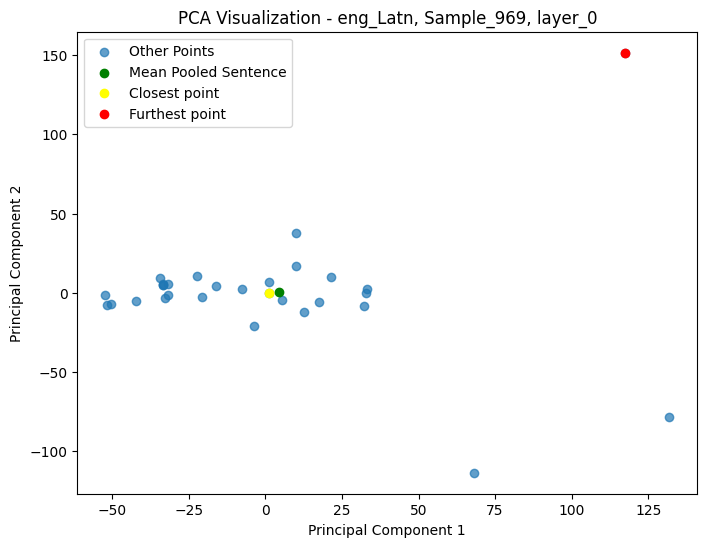


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: have




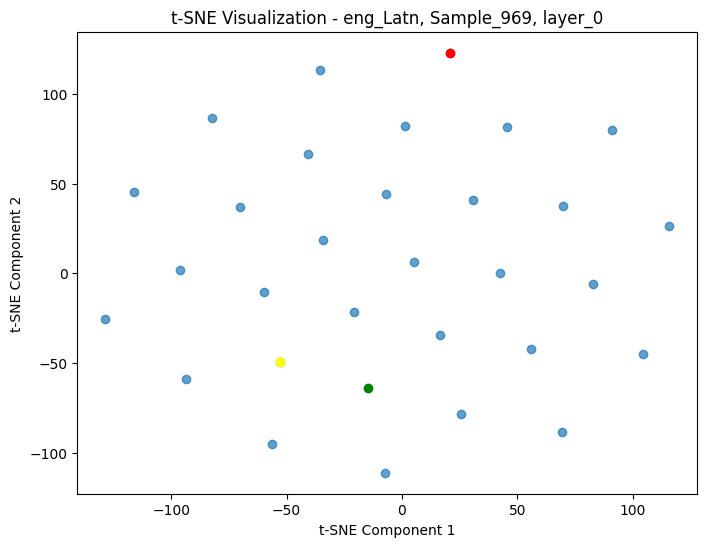


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: that
Furthest token to mean: to


In [124]:
FILE_PATH = "representations.h5"
with h5py.File(FILE_PATH, "r") as f:

    list_langs = list(f.keys())
    # print(list_langs)
    list_sample_ids = list(f[list_langs[0]].keys())
    # print(list_sample_ids)
    list_layer_ids = list(f[list_langs[0]][list_sample_ids[0]].keys())
    # print(list_layer_ids)

    # visualize any 1 sentence on any 1 layer for any 1 language (token reps and mean-pooled sentences)
    lang_index = 2
    sample_index = 0
    layer_index = 0

    closest_index, furthest_index = pca_visualize_one_sentence_one_layer_one_language(f[list_langs[lang_index]][list_sample_ids[sample_index]][list_layer_ids[layer_index]], list_langs[lang_index], list_sample_ids[sample_index], list_layer_ids[layer_index])
    visualized_sentence = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/sentence"]
    print()
    print(f"Visualized sentence: {visualized_sentence[()].decode('utf-8')}")
    sentence_input_ids = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/input_ids"]
    print(f"Closest token to mean: {tokenizer.decode(sentence_input_ids[closest_index])}")
    print(f"Furthest token to mean: {tokenizer.decode(sentence_input_ids[furthest_index])}")
    print()
    print()

    closest_index, furthest_index = tsne_visualize_one_sentence_one_layer_one_language(f[list_langs[lang_index]][list_sample_ids[sample_index]][list_layer_ids[layer_index]], list_langs[lang_index], list_sample_ids[sample_index], list_layer_ids[layer_index])
    visualized_sentence = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/sentence"]
    print()
    print(f"Visualized sentence: {visualized_sentence[()].decode('utf-8')}")
    sentence_input_ids = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/input_ids"]
    print(f"Closest token to mean: {tokenizer.decode(sentence_input_ids[closest_index])}")
    print(f"Furthest token to mean: {tokenizer.decode(sentence_input_ids[furthest_index])}")

    # visualize any 1 sentence on any 1 layer for all languages (token reps and mean-pooled sentences)
    # visualize_one_sentence_one_layer()

    # visualize all sentences on any 1 layer for any 1 language (mean-pooled sentences only)
    # visualize_all_sentences_one_layer_one_language()

    # visualize all sentences on any 1 layer for all languages (mean-pooled sentences only)
    # visualize_all_sentences_one_layer()




### Visualizations, 1 sentence on all layers for 1 language

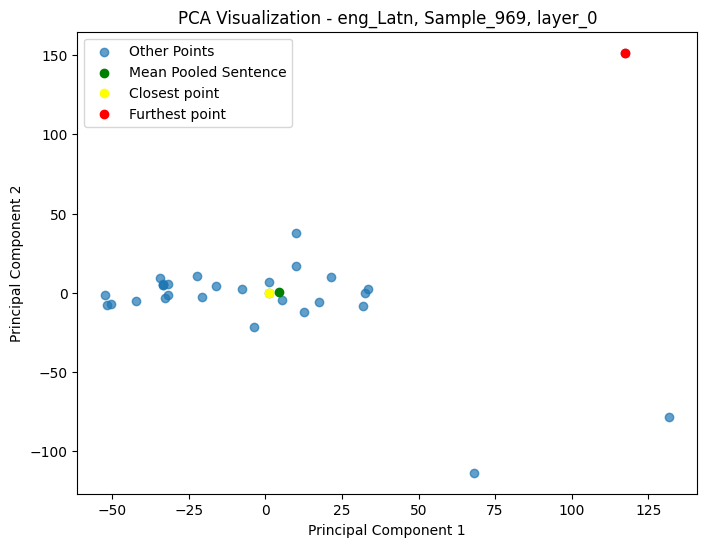


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: have




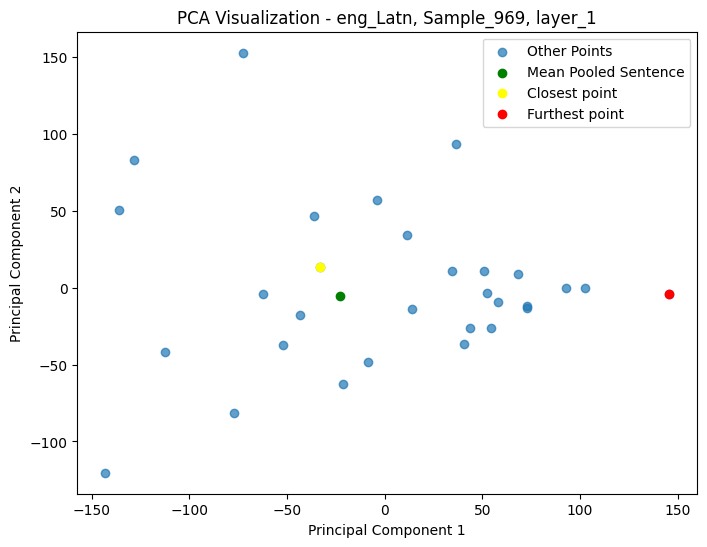


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: cliff




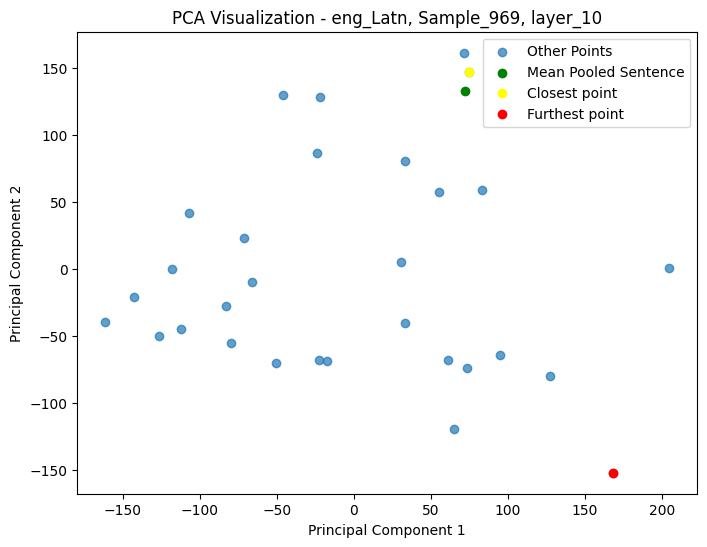


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: 
Furthest token to mean: ep




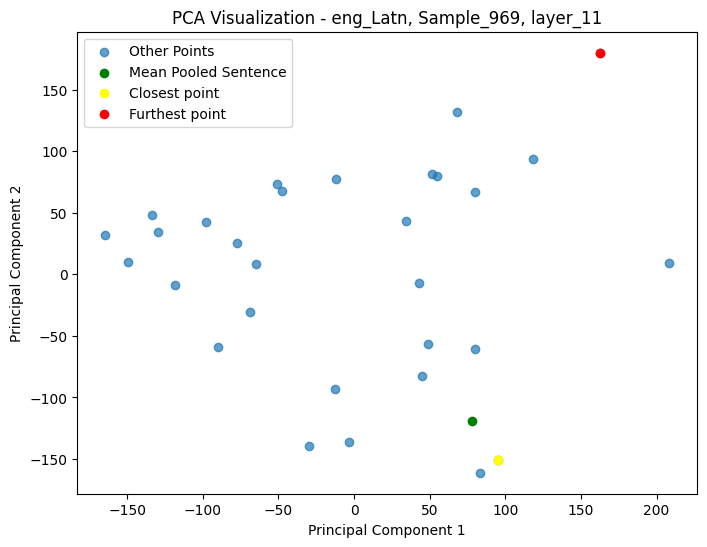


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: 
Furthest token to mean: ep




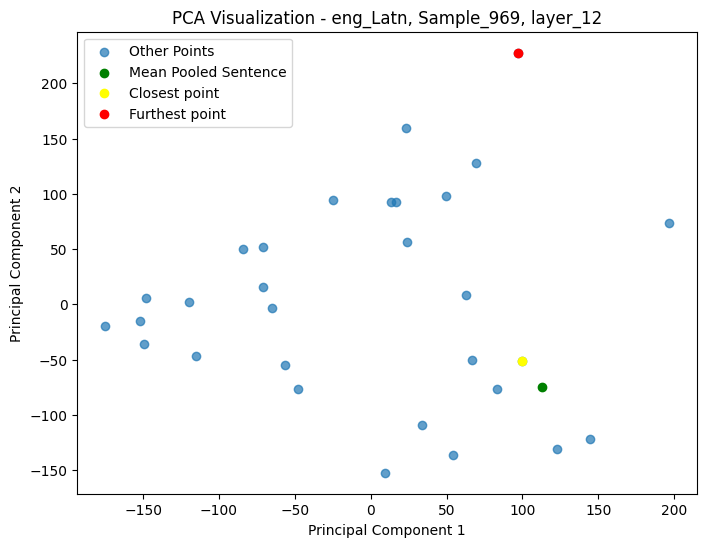


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: ep




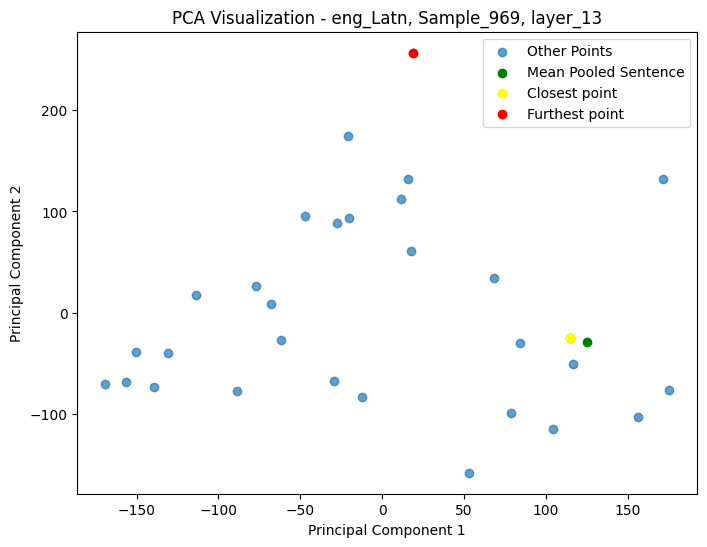


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: ep




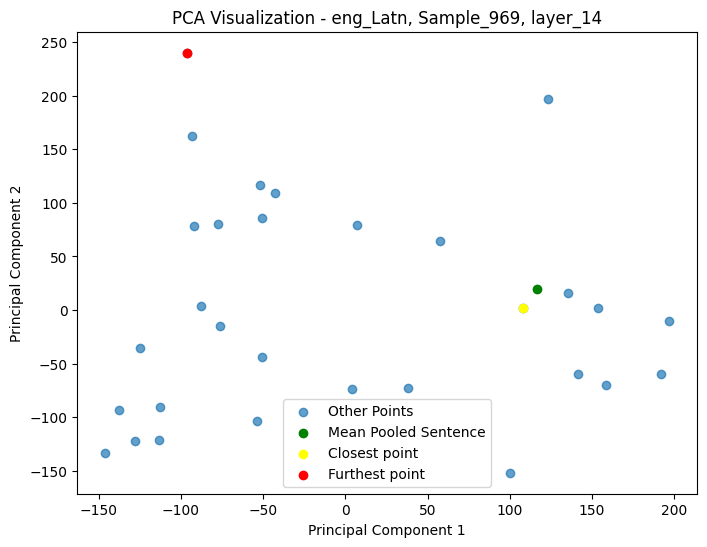


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: sea
Furthest token to mean: ep




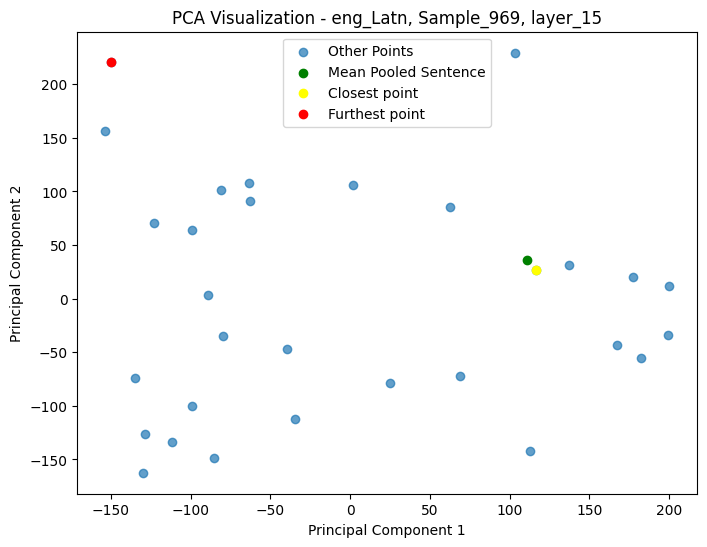


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: sea
Furthest token to mean: ep




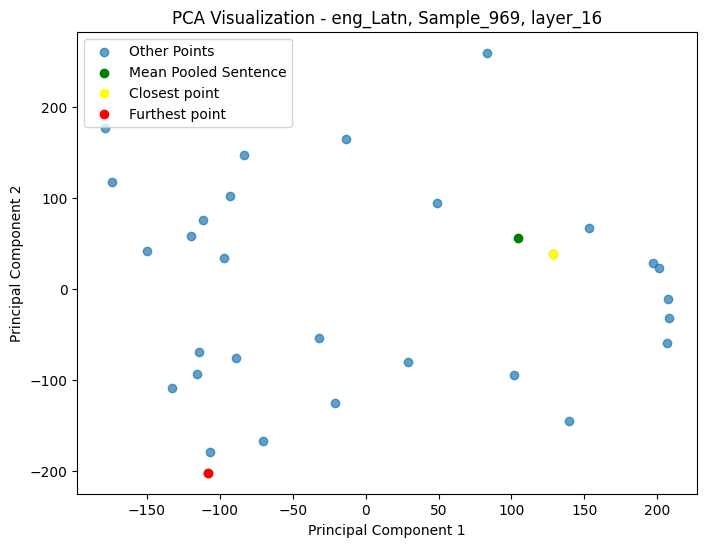


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: sea
Furthest token to mean: ,




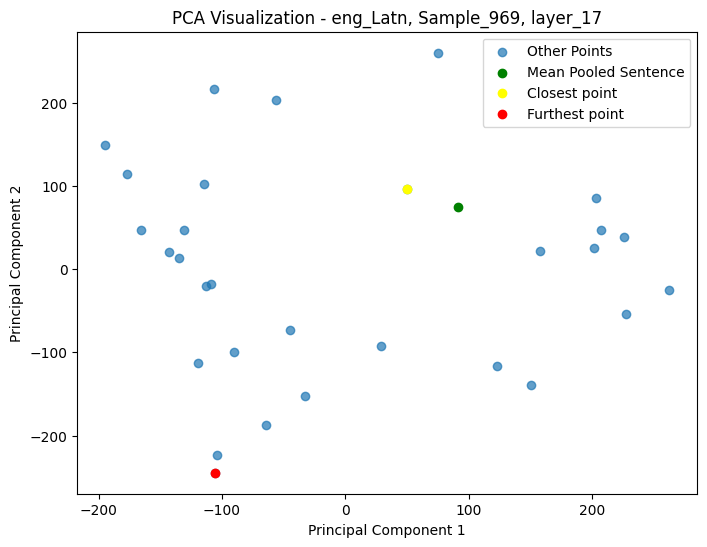


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: ,




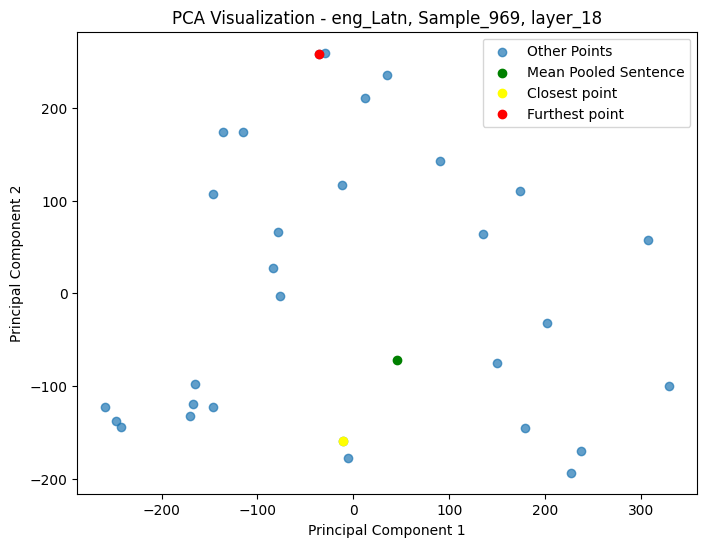


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: .
Furthest token to mean: ,




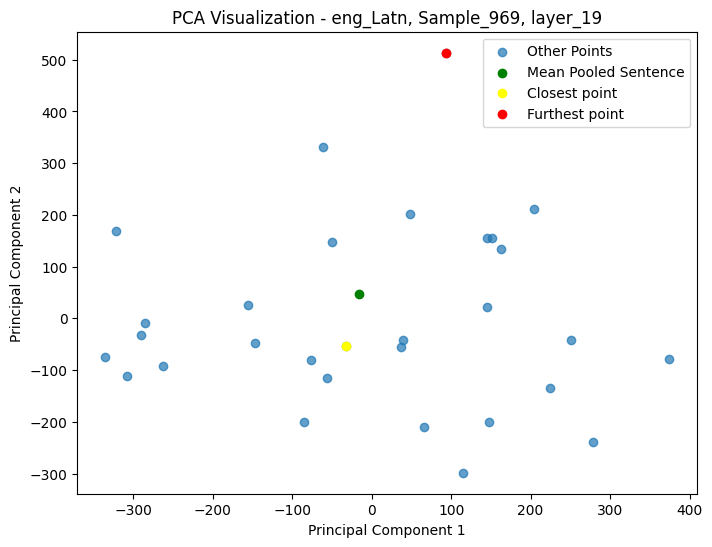


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: ste




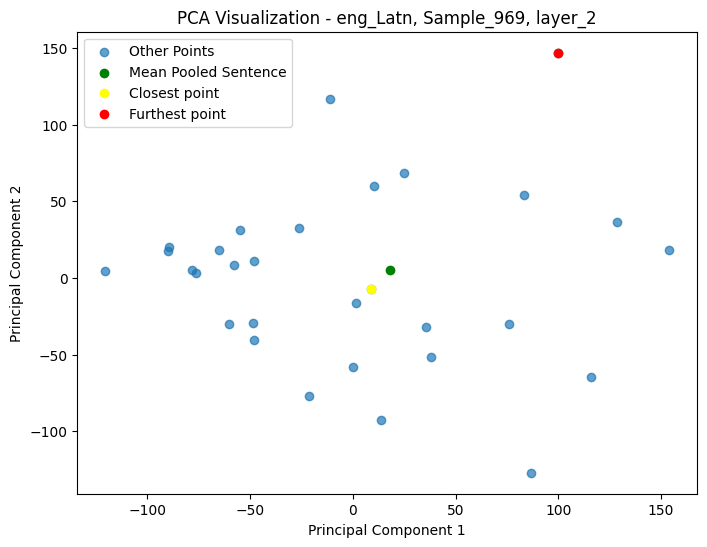


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: people
Furthest token to mean: ep




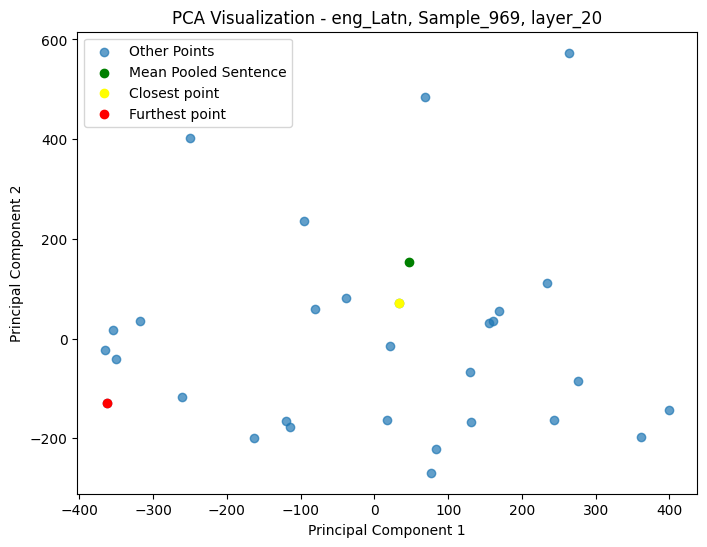


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: have
Furthest token to mean: landscape




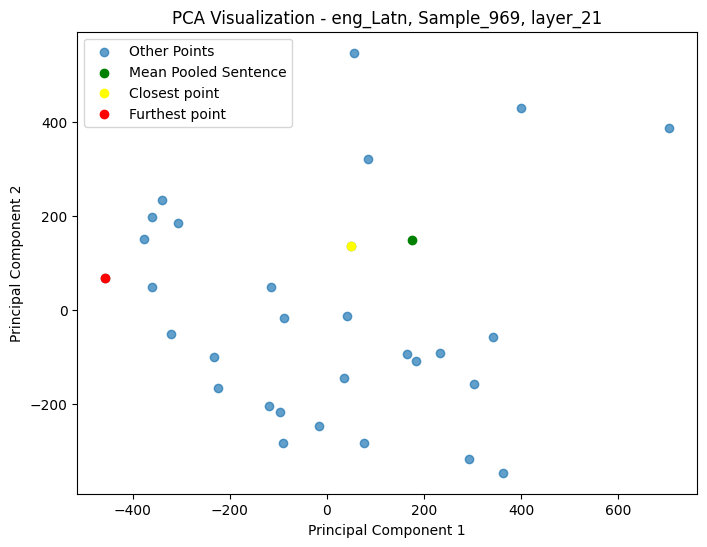


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: landscape




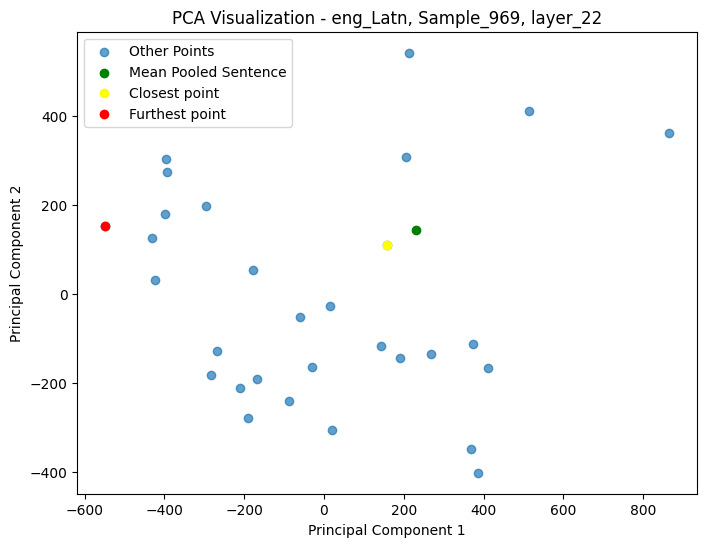


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: landscape




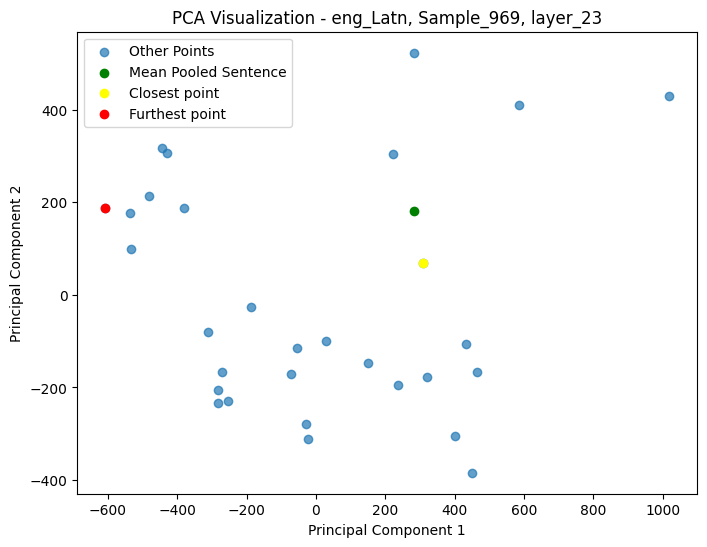


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: landscape




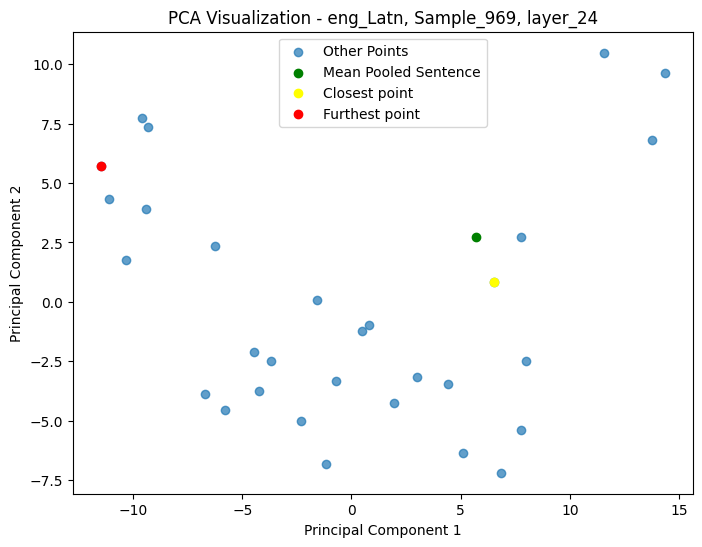


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: landscape




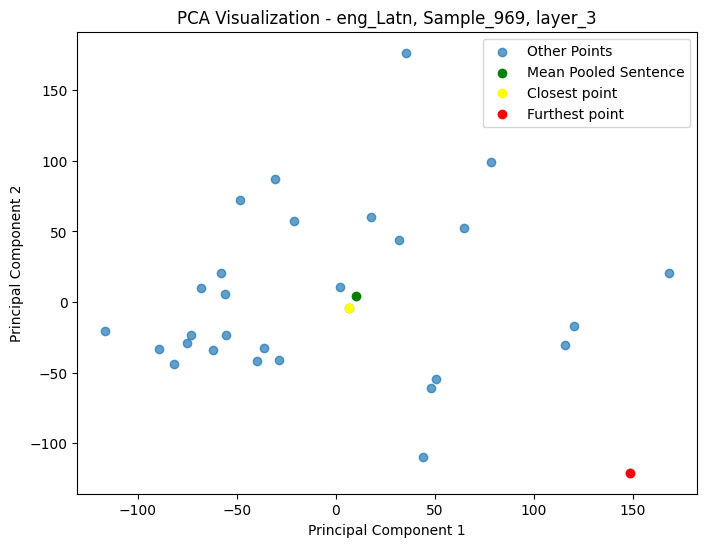


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: people
Furthest token to mean: ep




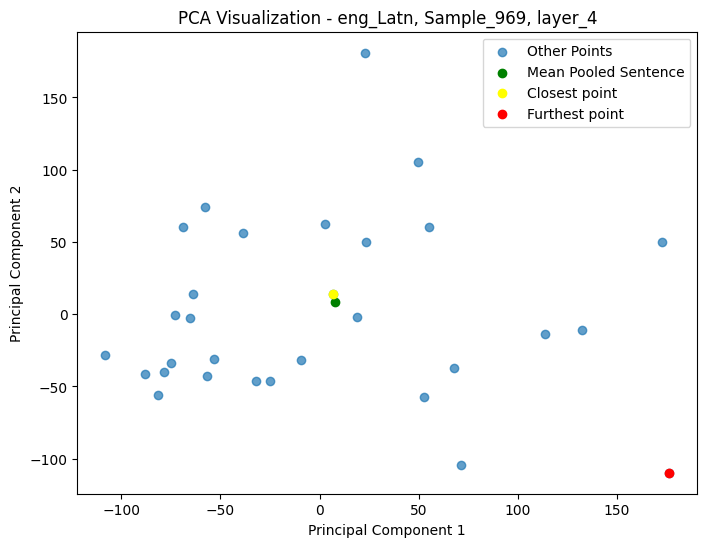


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: ep




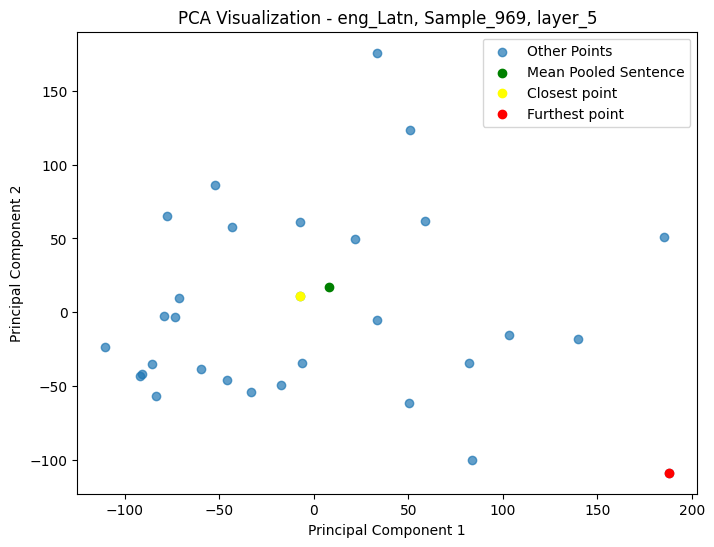


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: ep




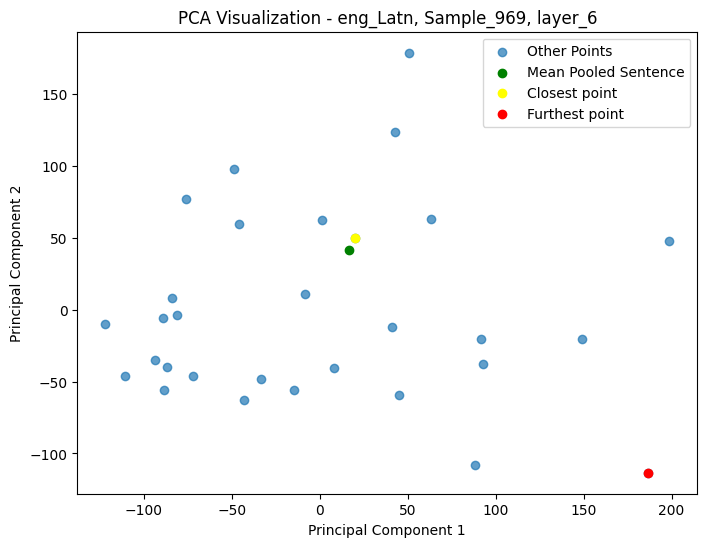


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: sea
Furthest token to mean: ep




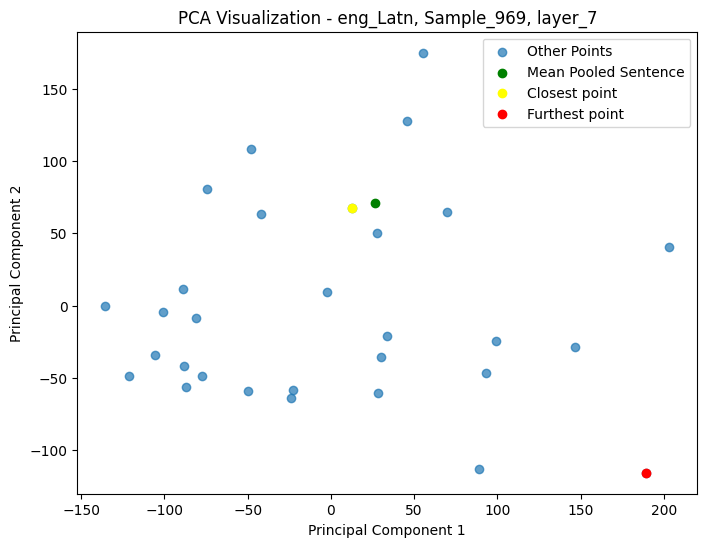


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: that
Furthest token to mean: ep




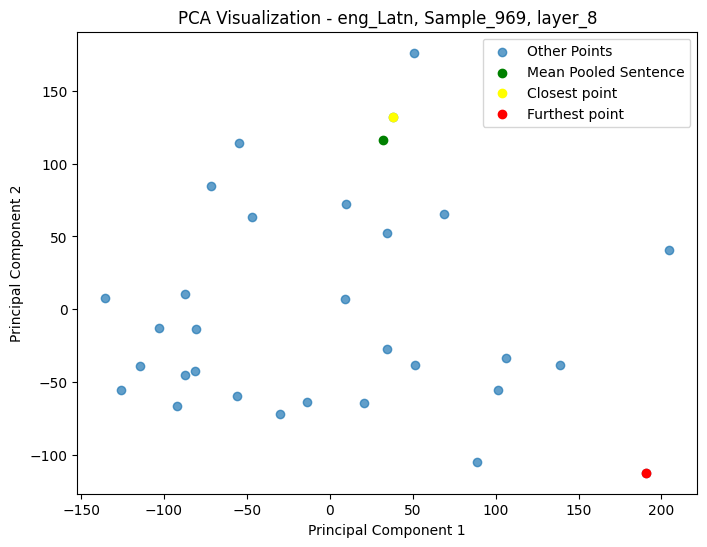


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: 
Furthest token to mean: ep




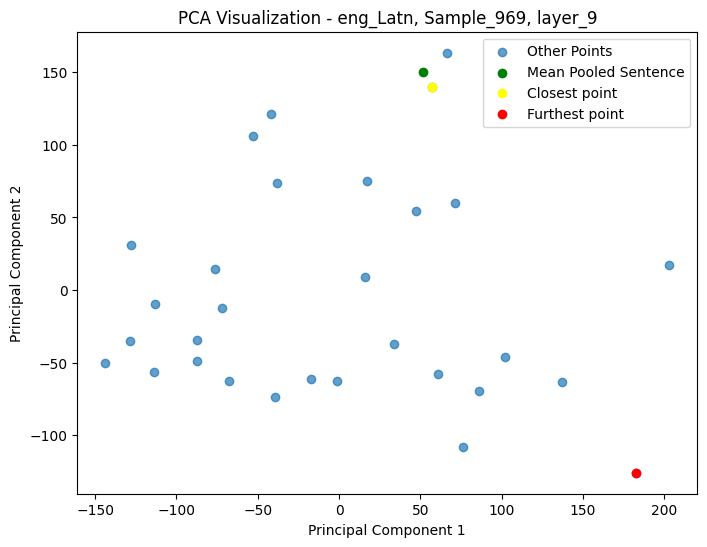


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: 
Furthest token to mean: ep




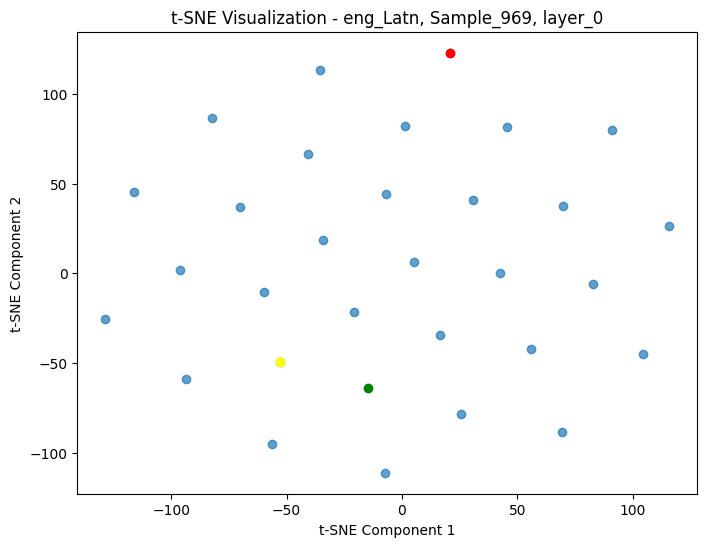


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: that
Furthest token to mean: to




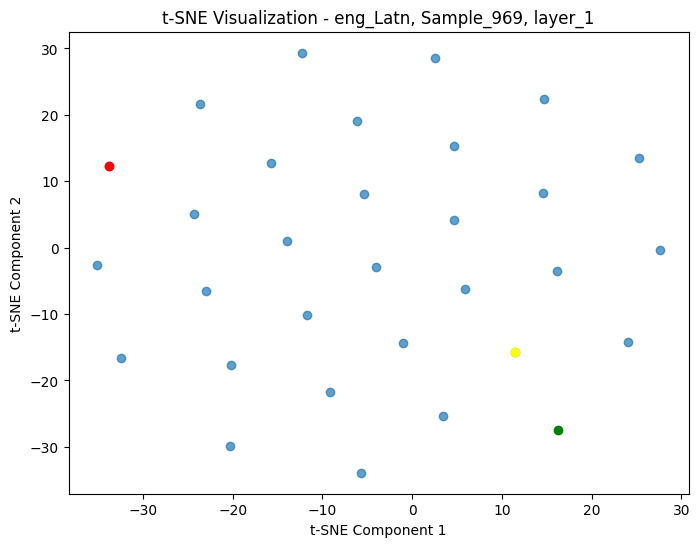


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: ste
Furthest token to mean: ,




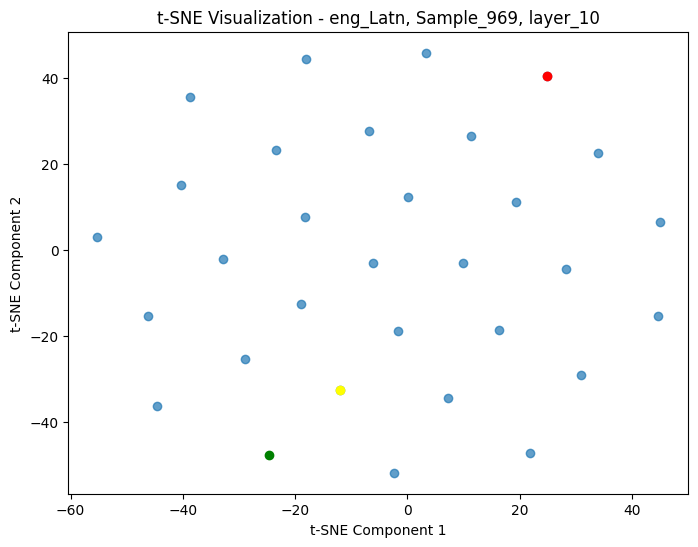


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: .
Furthest token to mean: up




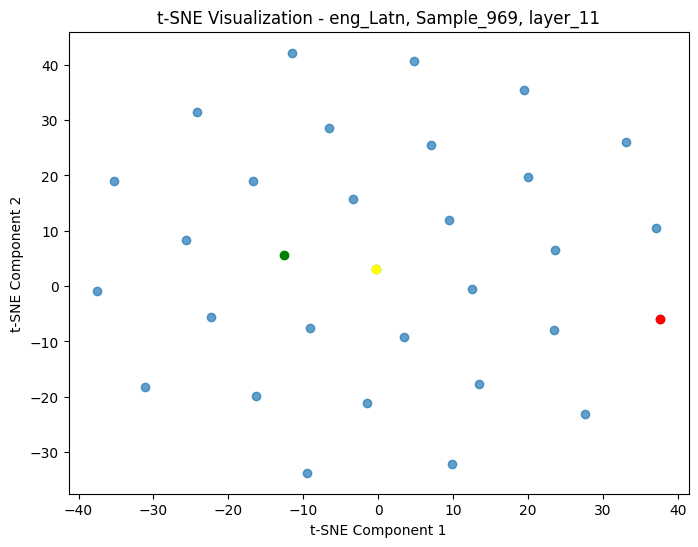


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: ugged
Furthest token to mean: have




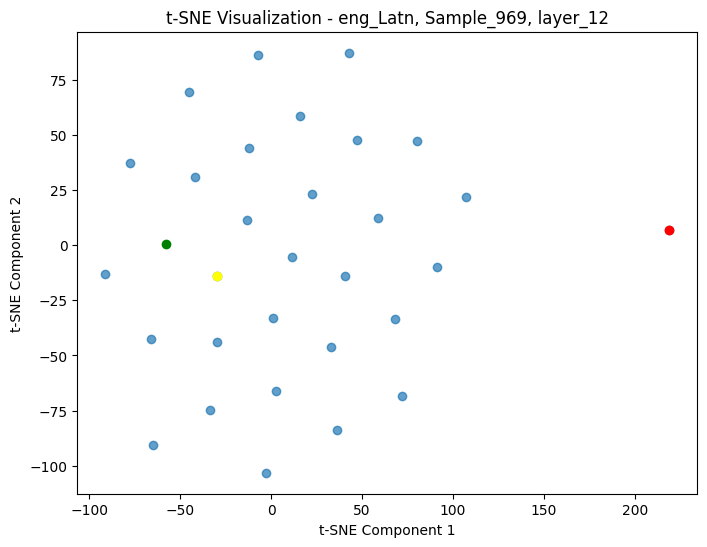


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: s
Furthest token to mean: centuries




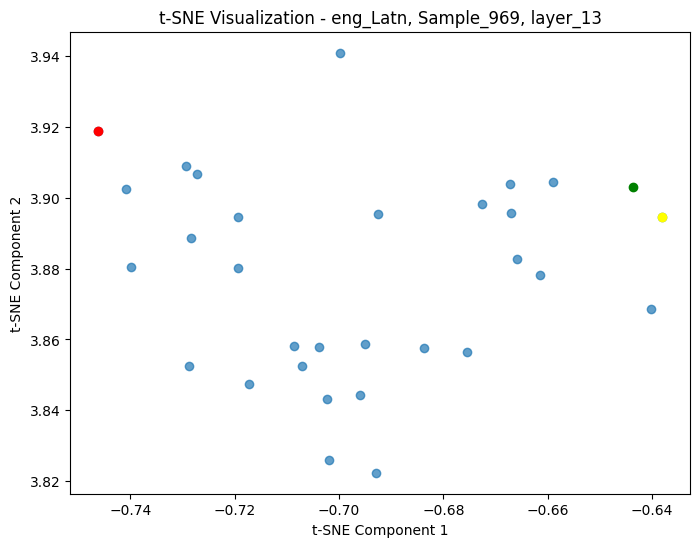


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: ep




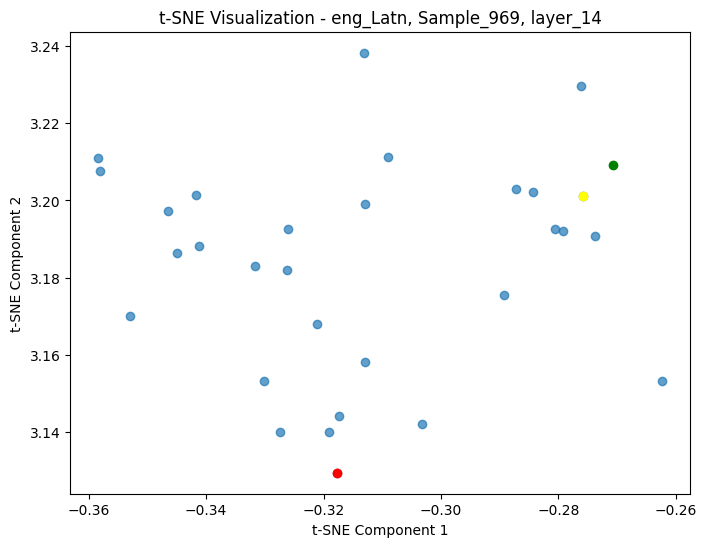


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: 
Furthest token to mean: ep




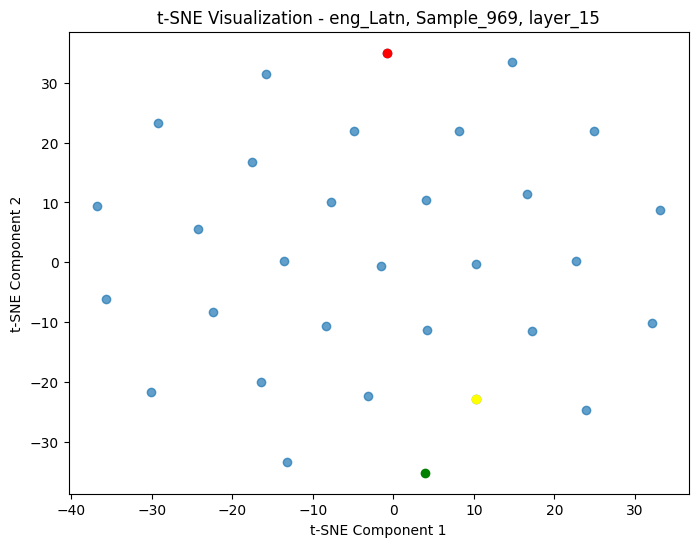


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: ugged




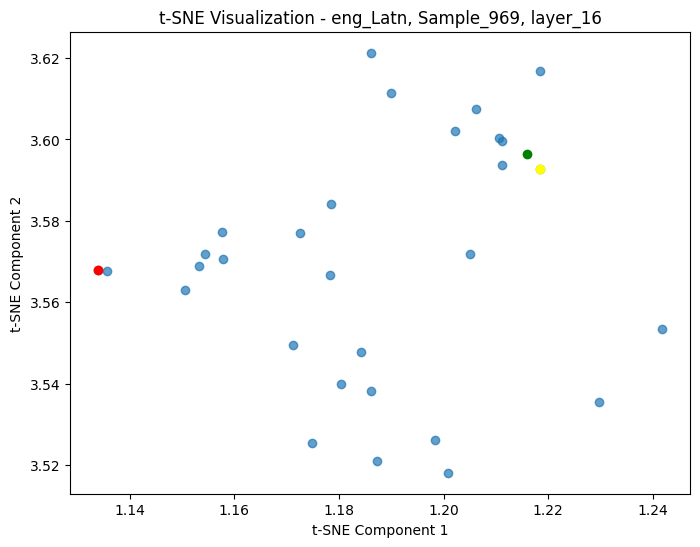


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: r




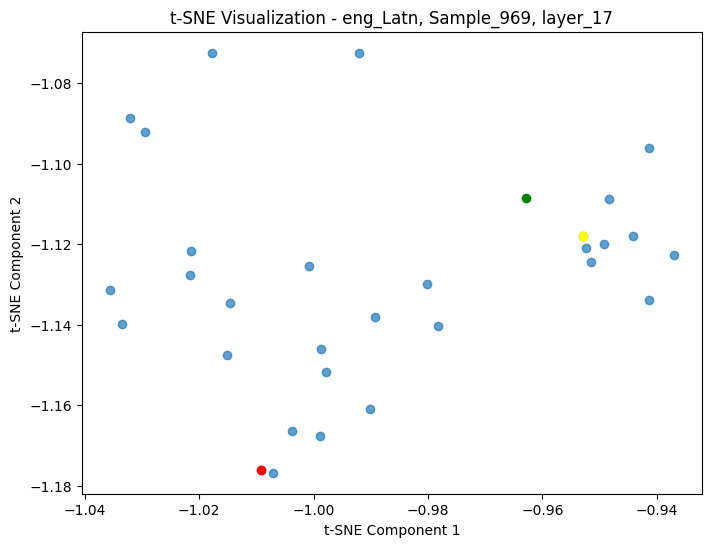


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: 
Furthest token to mean: r




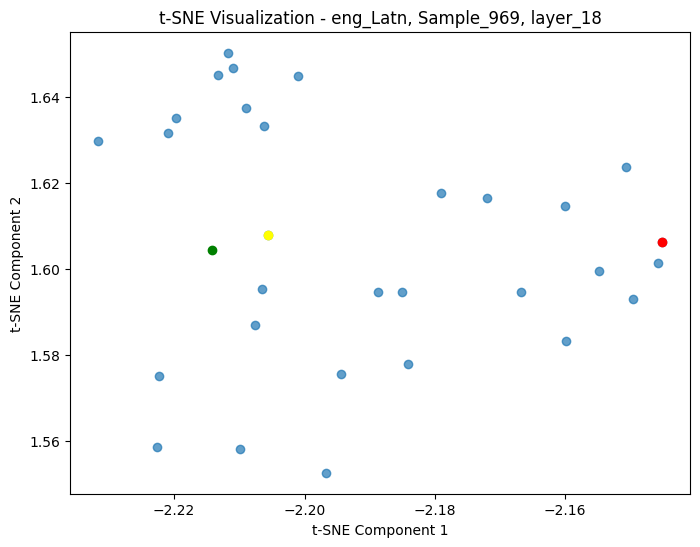


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: centuries
Furthest token to mean: on




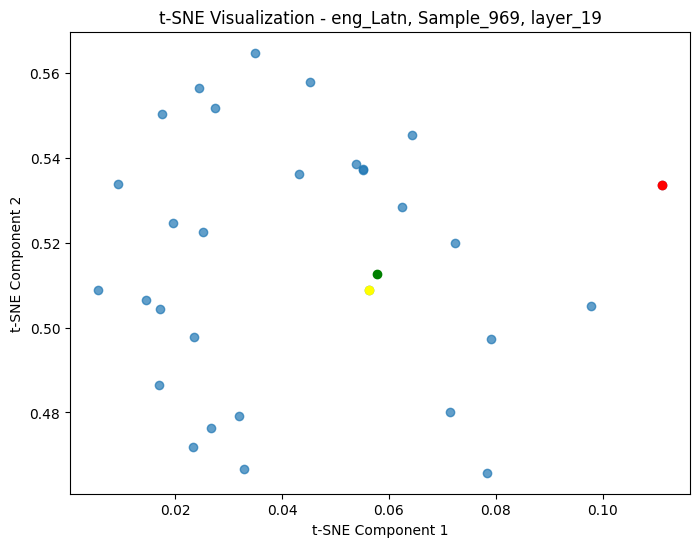


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: terra
Furthest token to mean: ste




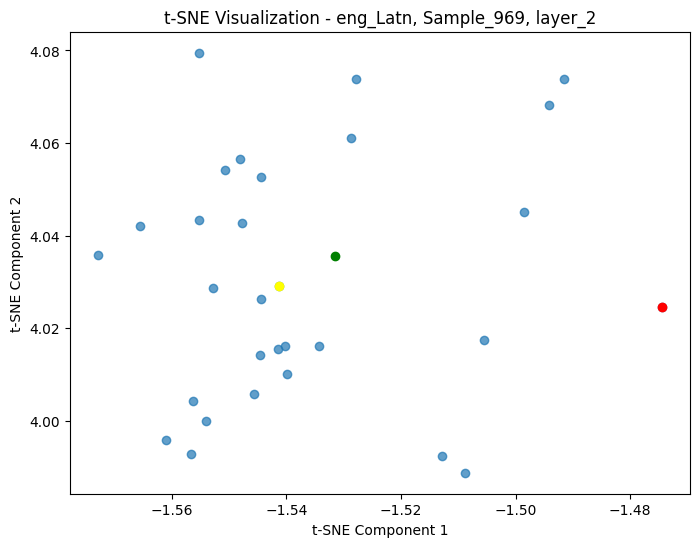


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: ,
Furthest token to mean: ep




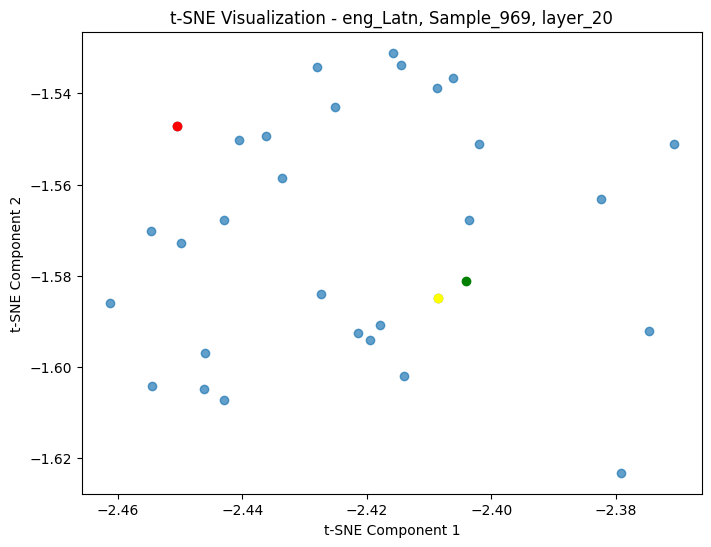


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: have
Furthest token to mean: right




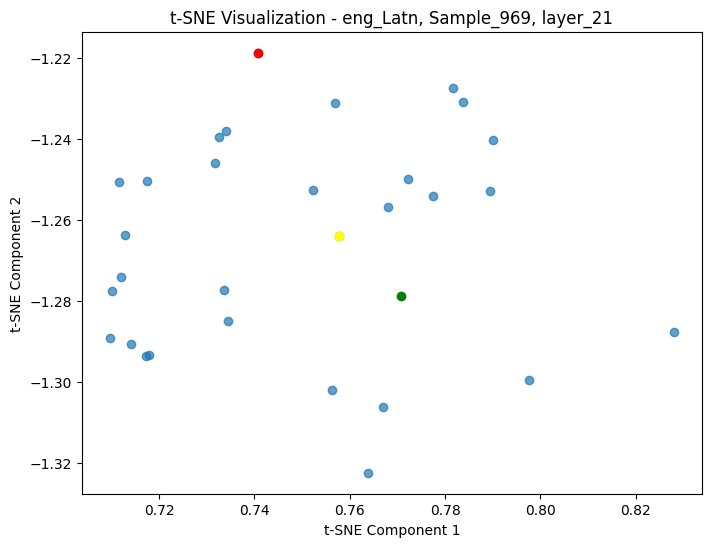


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: have
Furthest token to mean: cliff




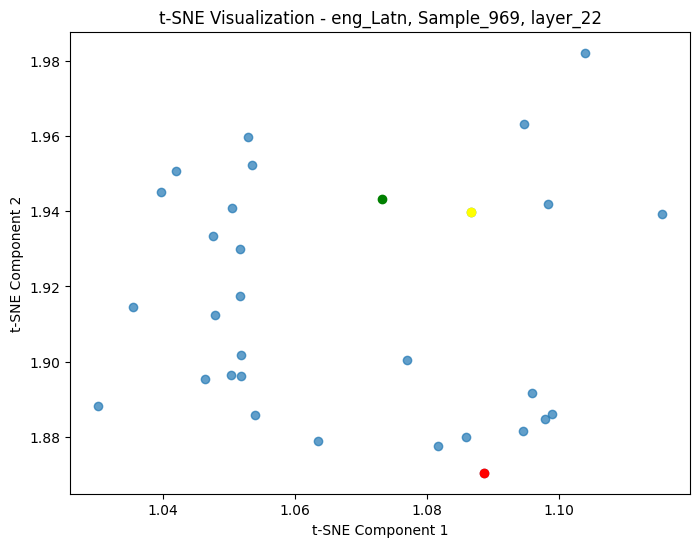


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: landscape




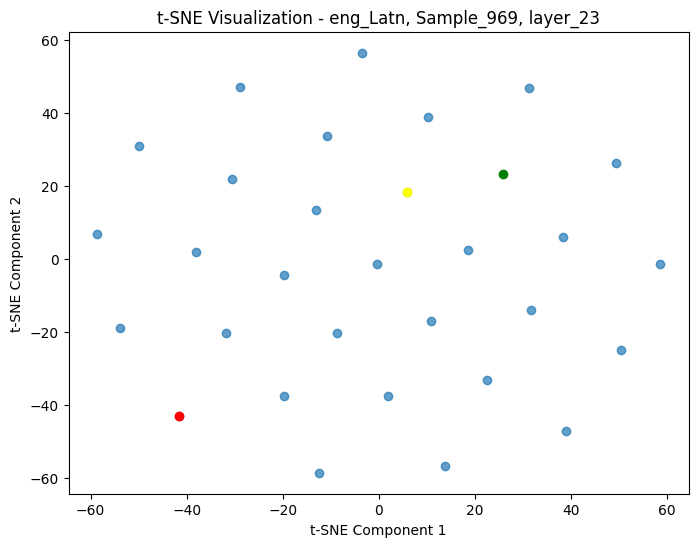


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: 
Furthest token to mean: people




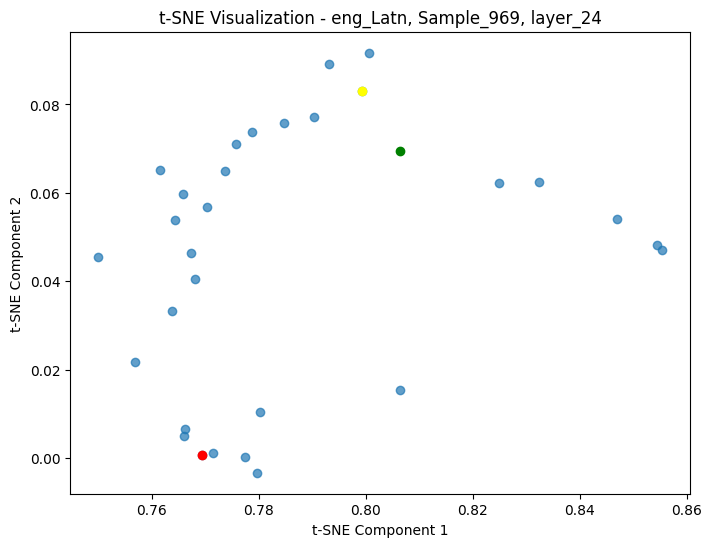


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: carefully
Furthest token to mean: landscape




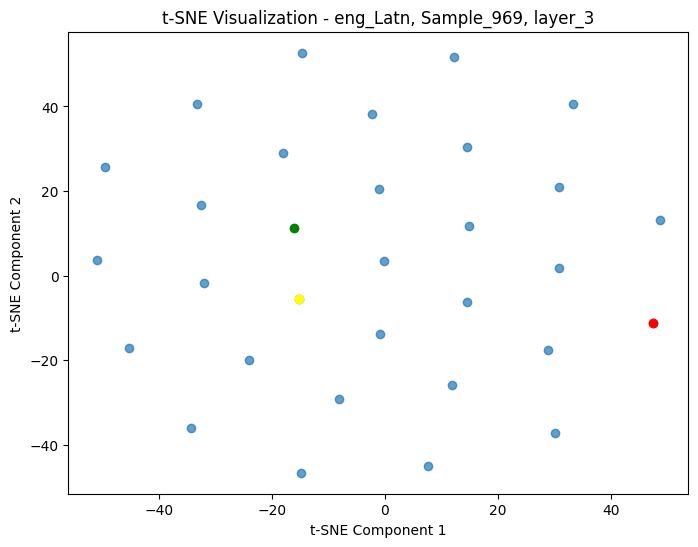


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: sea
Furthest token to mean: ces




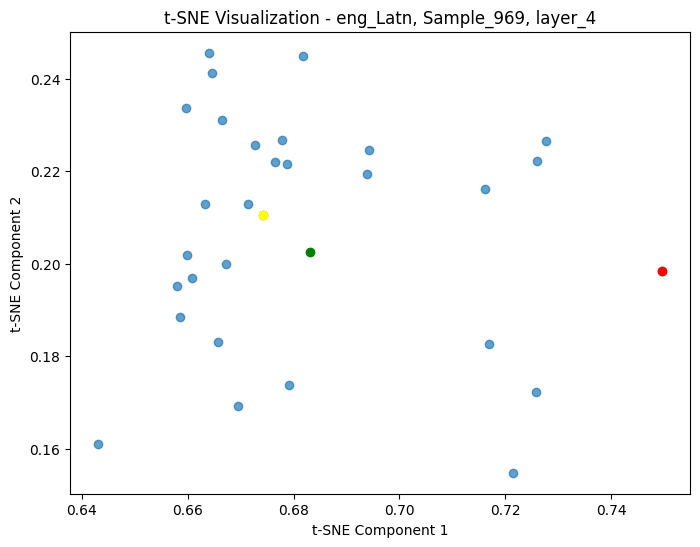


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: ,
Furthest token to mean: ep




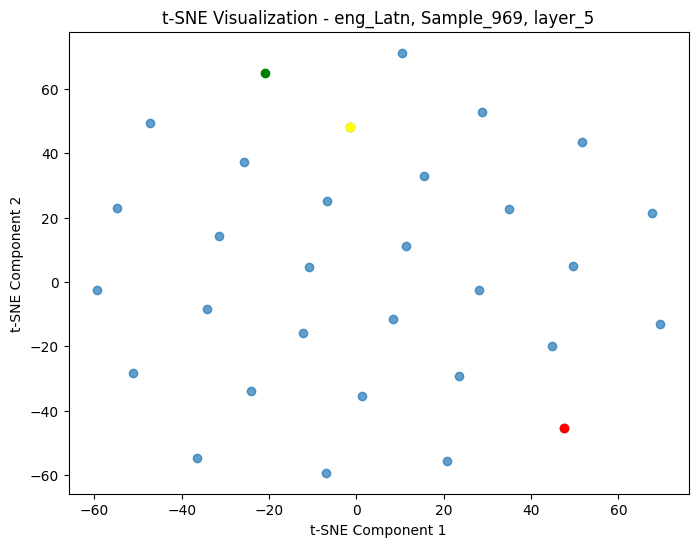


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: carefully
Furthest token to mean: r




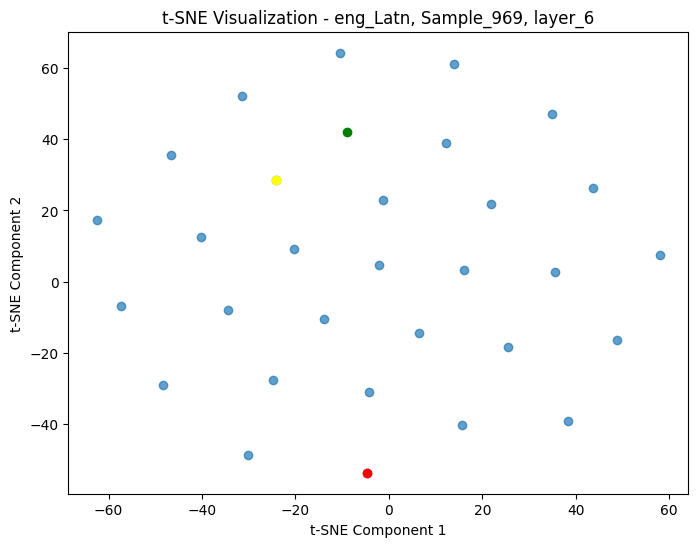


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: up
Furthest token to mean: ep




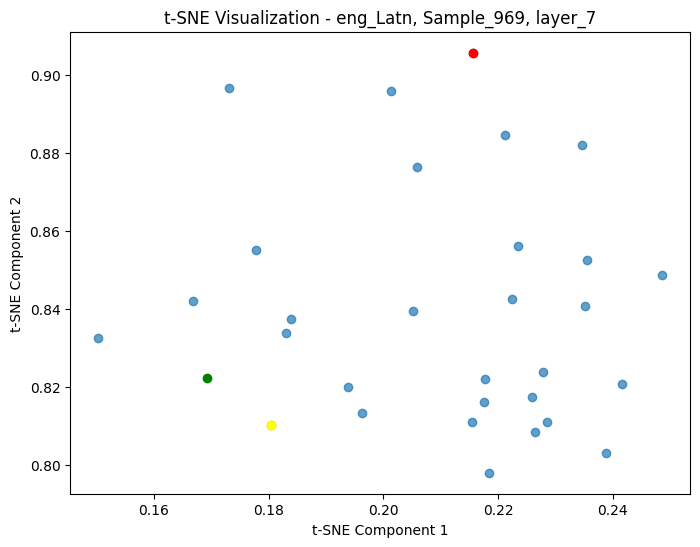


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: the
Furthest token to mean: ep




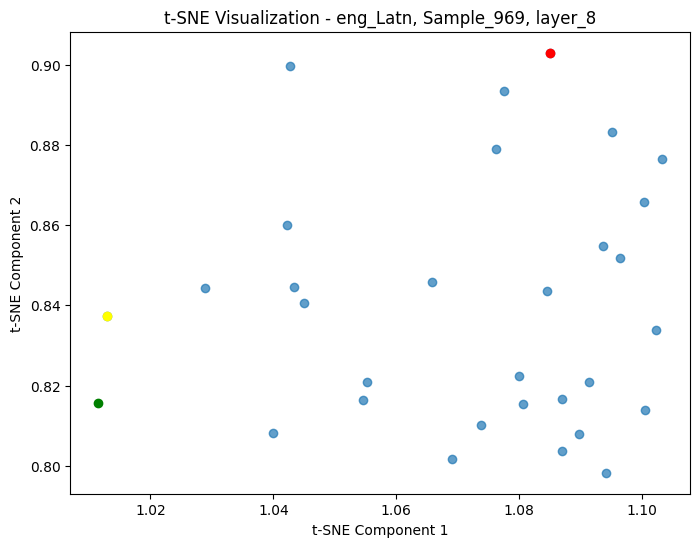


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: Over
Furthest token to mean: ep




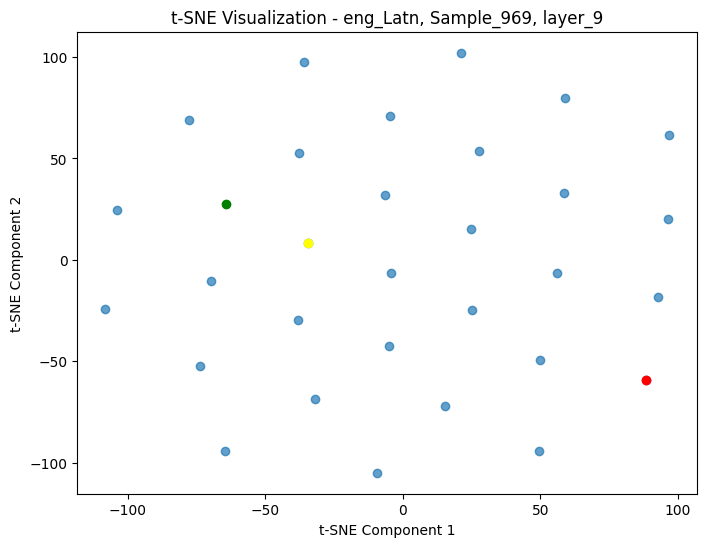


Visualized sentence: Over the centuries, people have carefully built terraces on the rugged, steep landscape right up to the cliffs that overlook the sea.
Closest token to mean: ste
Furthest token to mean: have




In [125]:
with h5py.File(FILE_PATH, "r") as f:

    list_langs = list(f.keys())
    # print(list_langs)
    list_sample_ids = list(f[list_langs[0]].keys())
    # print(list_sample_ids)
    list_layer_ids = list(f[list_langs[0]][list_sample_ids[0]].keys())
    # print(list_layer_ids)

    # visualize any 1 sentence on any 1 layer for any 1 language (token reps and mean-pooled sentences)
    lang_index = 2
    sample_index = 0

    # PCA layers
    for layer_index in range(len(list_layer_ids)):
        closest_index, furthest_index = pca_visualize_one_sentence_one_layer_one_language(f[list_langs[lang_index]][list_sample_ids[sample_index]][list_layer_ids[layer_index]], list_langs[lang_index], list_sample_ids[sample_index], list_layer_ids[layer_index])
        visualized_sentence = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/sentence"]
        print()
        print(f"Visualized sentence: {visualized_sentence[()].decode('utf-8')}")
        sentence_input_ids = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/input_ids"]
        print(f"Closest token to mean: {tokenizer.decode(sentence_input_ids[closest_index])}")
        print(f"Furthest token to mean: {tokenizer.decode(sentence_input_ids[furthest_index])}")
        print()
        print()

    # tSNE layers
    for layer_index in range(len(list_layer_ids)):
        closest_index, furthest_index = tsne_visualize_one_sentence_one_layer_one_language(f[list_langs[lang_index]][list_sample_ids[sample_index]][list_layer_ids[layer_index]], list_langs[lang_index], list_sample_ids[sample_index], list_layer_ids[layer_index])
        visualized_sentence = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/sentence"]
        print()
        print(f"Visualized sentence: {visualized_sentence[()].decode('utf-8')}")
        sentence_input_ids = f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/input_ids"]
        print(f"Closest token to mean: {tokenizer.decode(sentence_input_ids[closest_index])}")
        print(f"Furthest token to mean: {tokenizer.decode(sentence_input_ids[furthest_index])}")
        print()
        print()

### Visualizations, all sentences on 1 layer for 1 language

In [130]:
def pca_visualize_all_sentences_one_layer_one_language(hidden_representations, lang, layer_id):
    # convert to 2D array for pca input
    # pca_input = np.vstack(list(hidden_representations.values()))
    pca_input = hidden_representations

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_input)

    # Visualize PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, label='Mean Pooled Sentences')

    plt.title(f"PCA Visualization (all sentences) - {lang}, {layer_id}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()


In [148]:
def tsne_visualize_all_sentences_one_layer_one_language(hidden_representations, lang, layer_id):
    # convert to 2D array for tsne input
    tsne_input = np.array(hidden_representations)

    # set perplexity according to sample_size
    perplexity_value = min(tsne_input.shape[0] - 1, 30)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=1000, random_state=42)
    tsne_result = tsne.fit_transform(tsne_input)

    # Visualize tSNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, label='Other Points')

    plt.title(f"t-SNE Visualization (all sentences) - {lang}, {layer_id}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

    return closest_index, furthest_index


PCA visualizations, all sentences, 1 layer (layer_0), 1 language (eng_Latn)


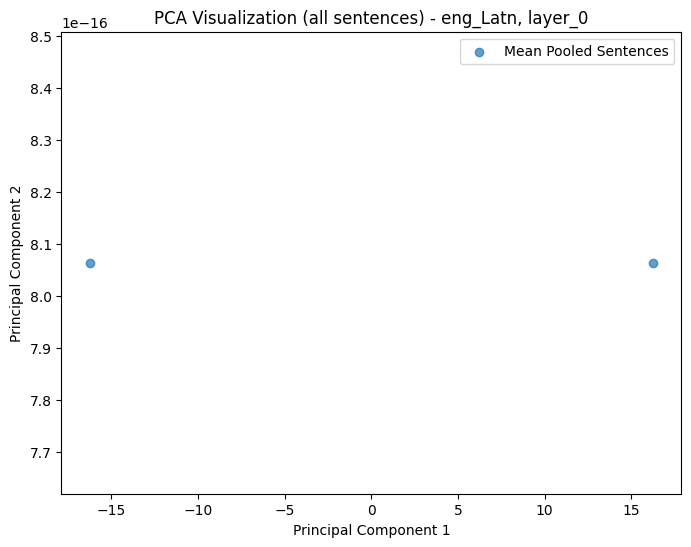


#######################################################################################

tSNE visualizations, all sentences, 1 layer (layer_0), 1 language (eng_Latn)


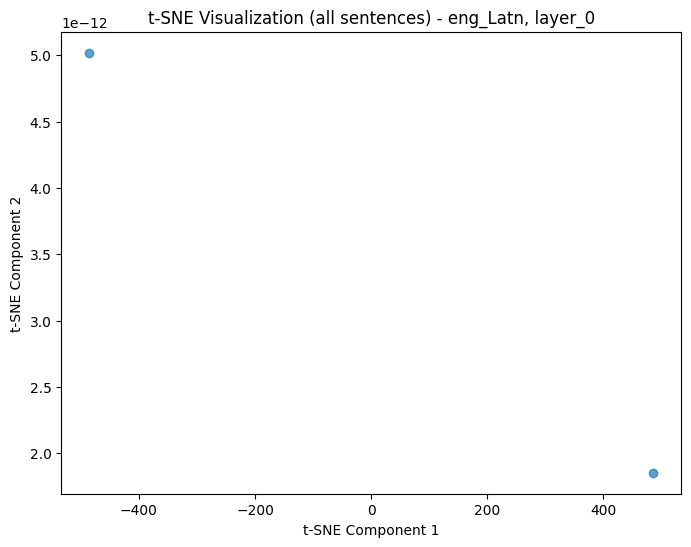

In [152]:
with h5py.File(FILE_PATH, "r") as f:

    list_langs = list(f.keys())
    # print(list_langs)
    list_sample_ids = list(f[list_langs[0]].keys())
    # print(list_sample_ids)
    list_layer_ids = list(f[list_langs[0]][list_sample_ids[0]].keys())
    # print(list_layer_ids)

    # visualize all sentences on any 1 layer for any 1 language (mean-pooled sentences only)
    lang_index = 2
    layer_index = 0

    mean_pooled_samples = []
    for sample_index in range(len(list_sample_ids)):
        mean_pooled_samples.append(f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/{list_layer_ids[layer_index]}/mean_pooled_sentence"])

    # PCA visualizations
    print(f'PCA visualizations, all sentences, 1 layer ({list_layer_ids[layer_index]}), 1 language ({list_langs[lang_index]})')
    pca_visualize_all_sentences_one_layer_one_language(mean_pooled_samples, list_langs[lang_index], list_layer_ids[layer_index])
    print()

    print('#######################################################################################')
    print()
    # tSNE visualizations
    print(f'tSNE visualizations, all sentences, 1 layer ({list_layer_ids[layer_index]}), 1 language ({list_langs[lang_index]})')
    tsne_visualize_all_sentences_one_layer_one_language(mean_pooled_samples, list_langs[lang_index], list_layer_ids[layer_index])


### Visualizations, all sentences on all layers for 1 language

PCA visualizations, all sentences, all layers, 1 language (eng_Latn)


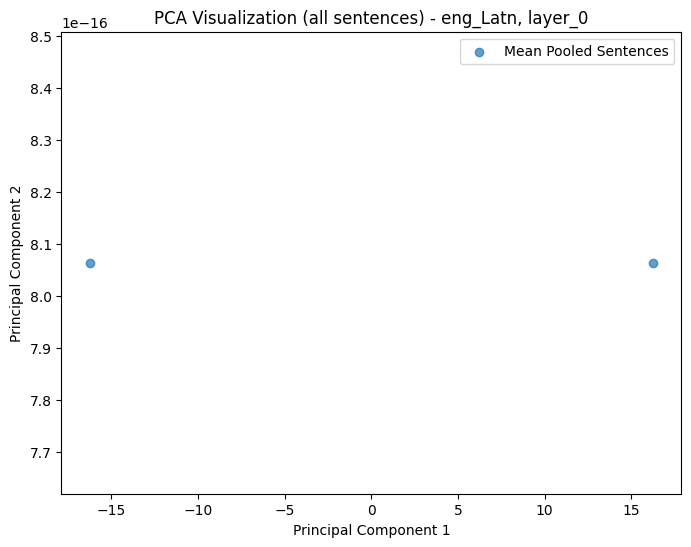

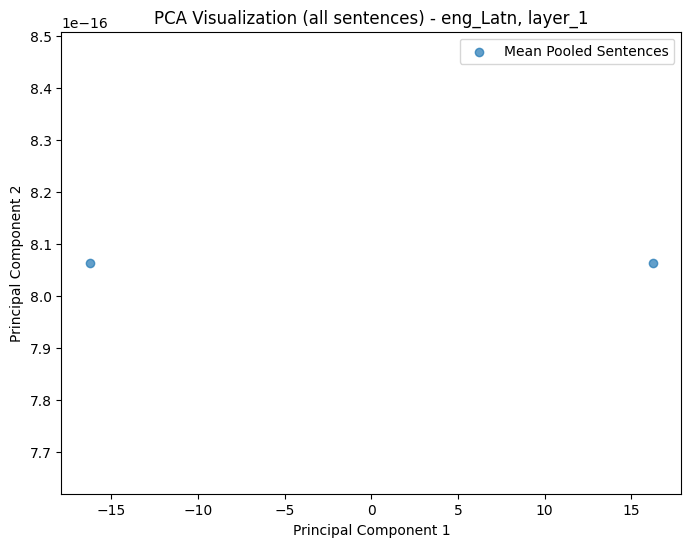

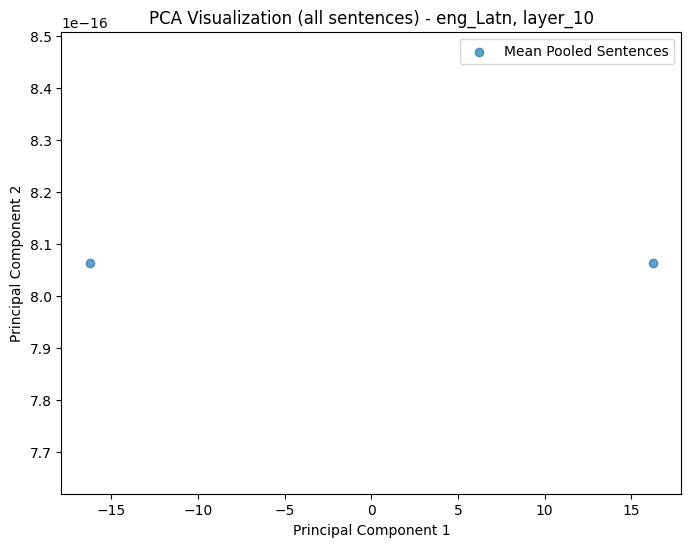

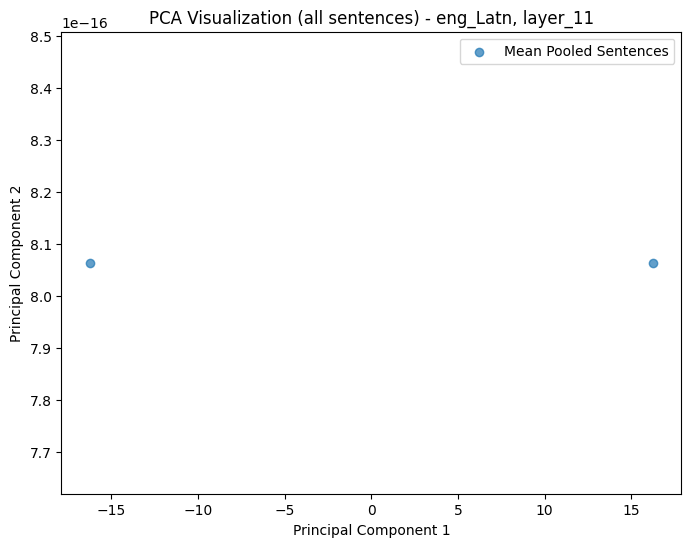

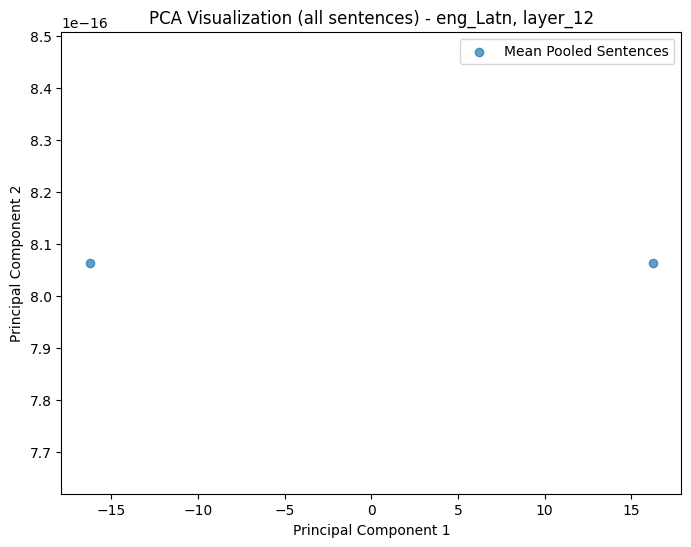

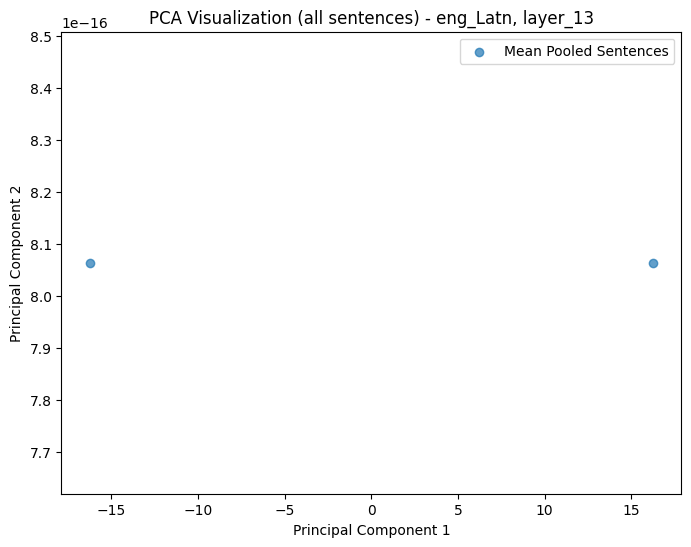

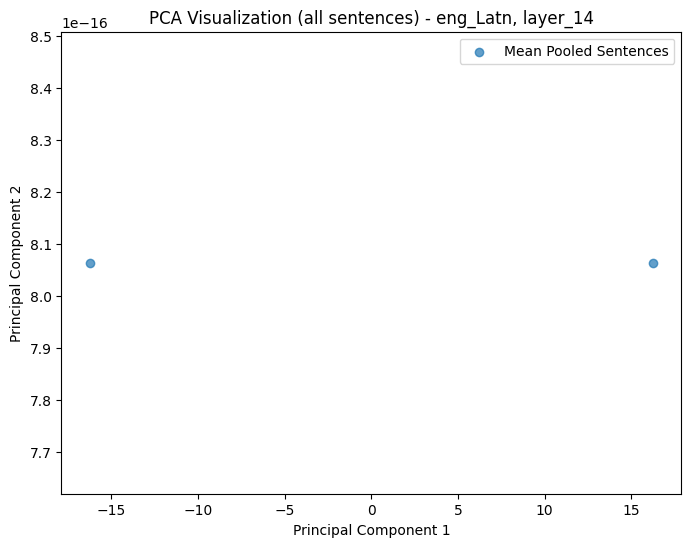

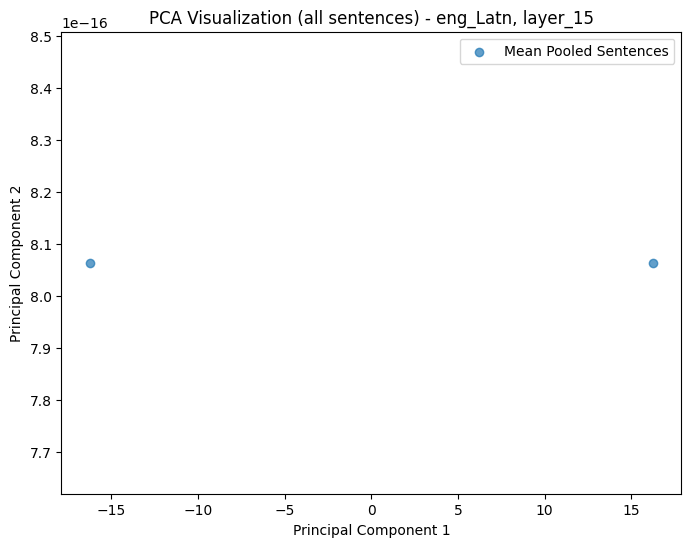

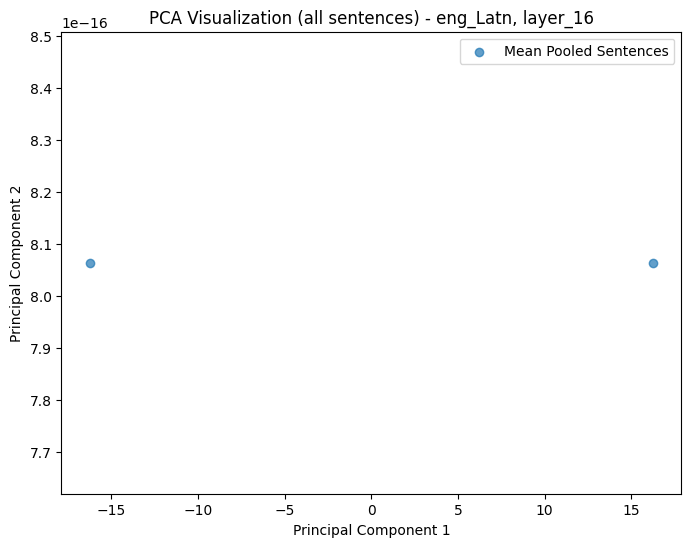

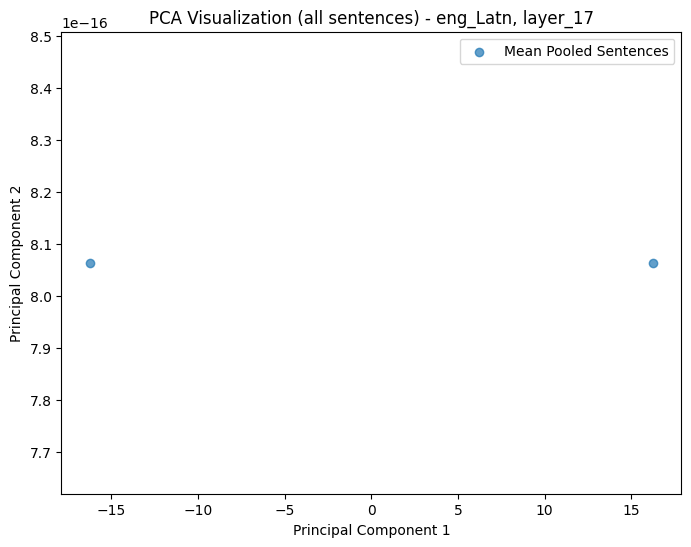

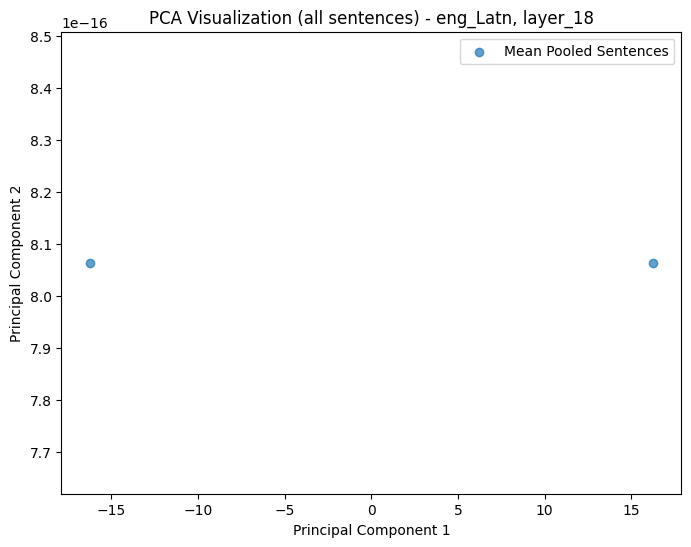

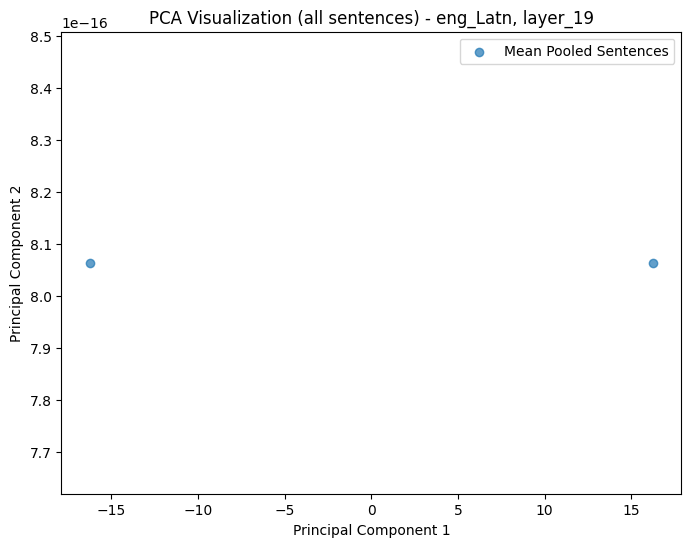

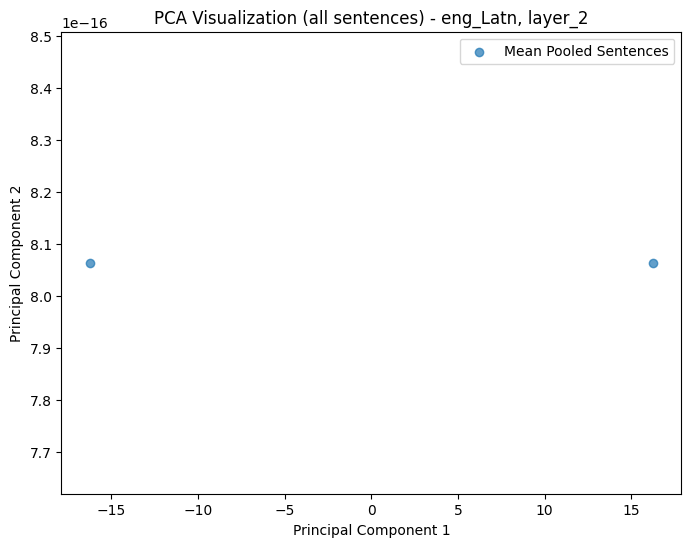

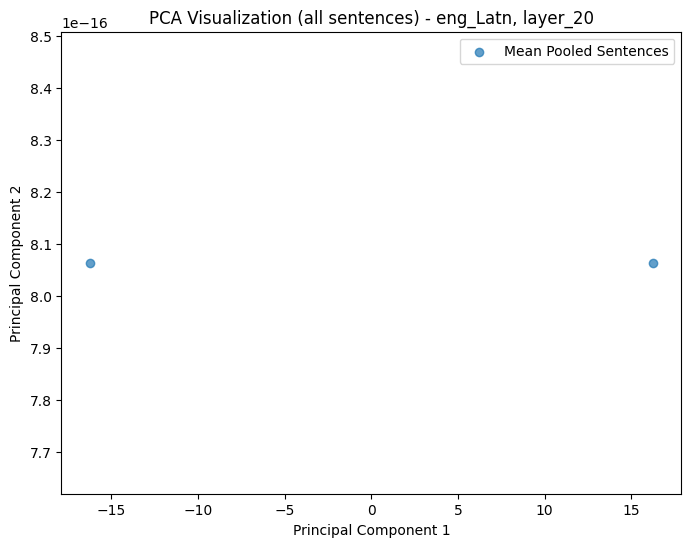

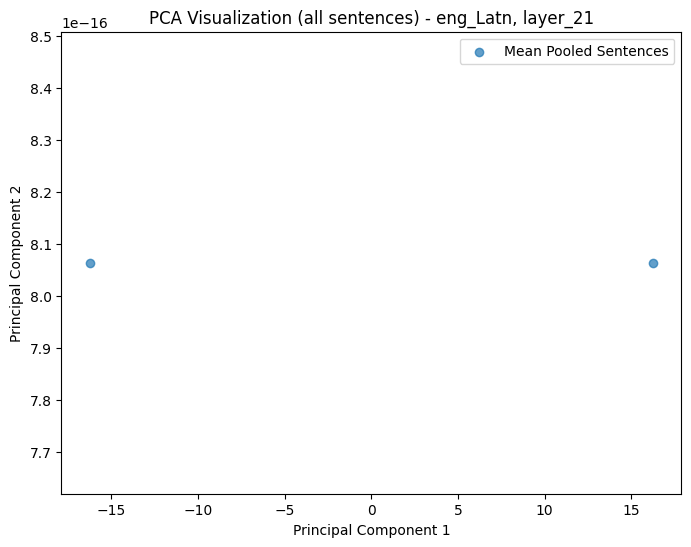

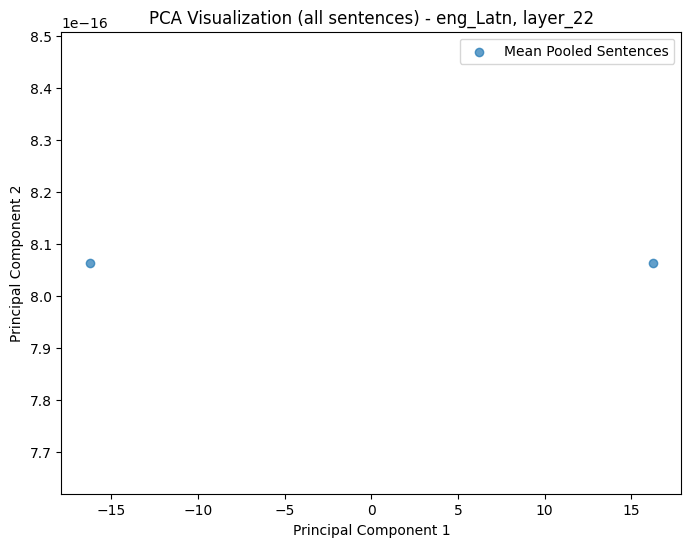

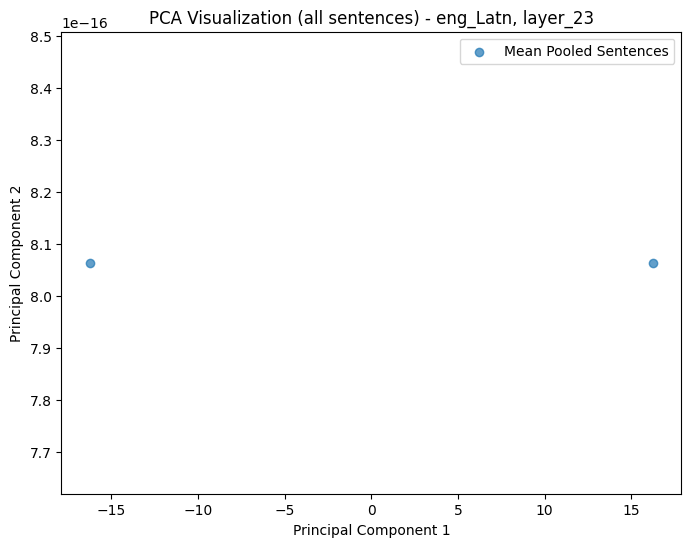

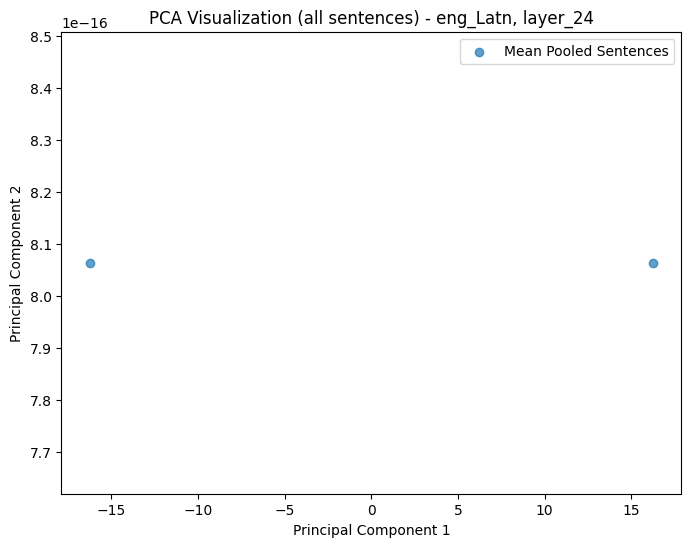

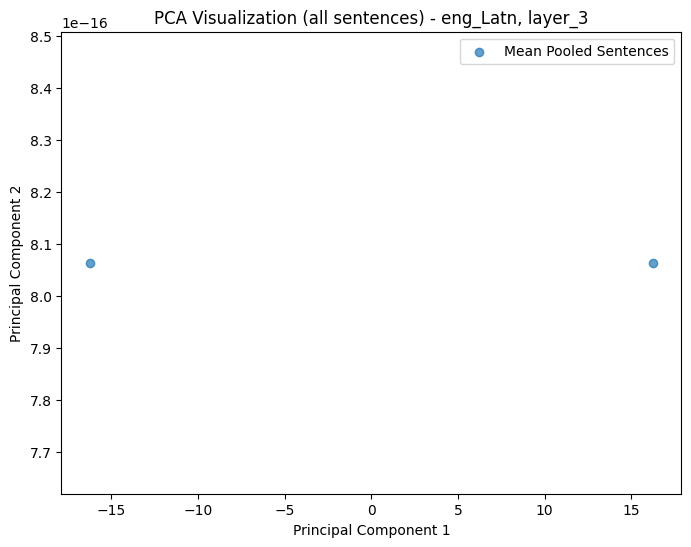

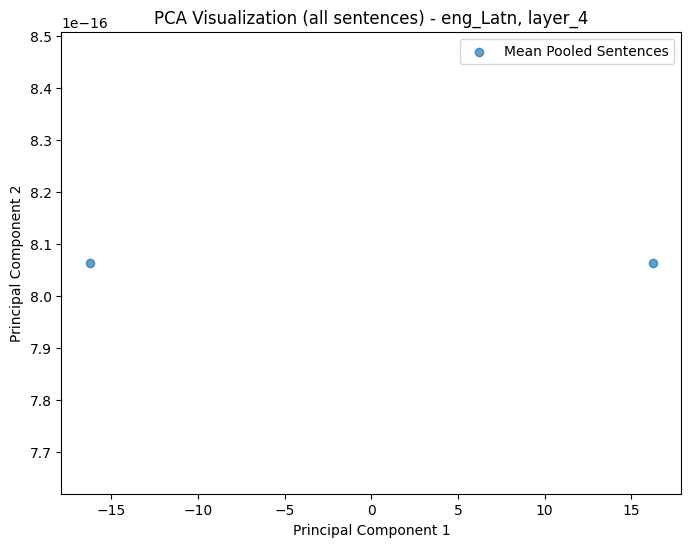

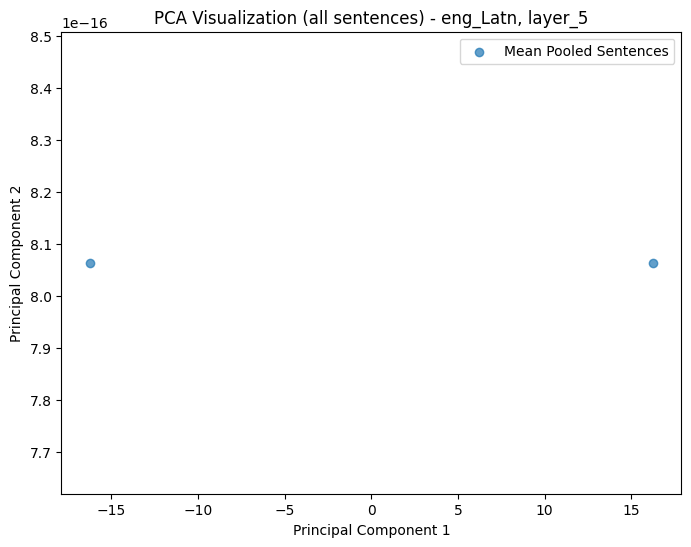

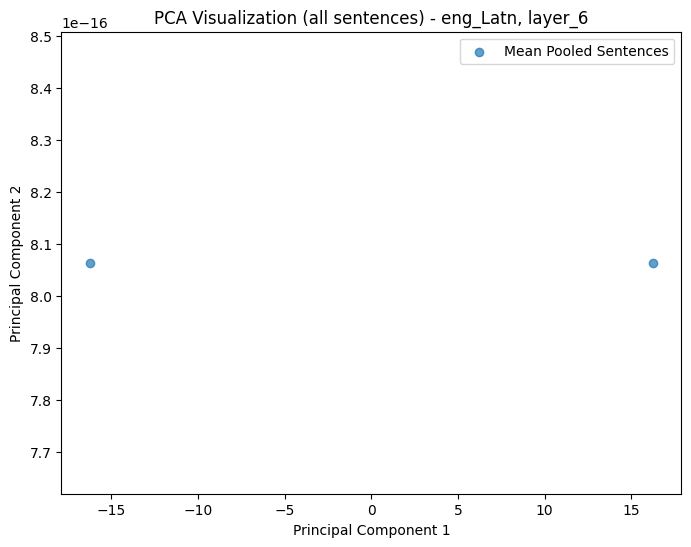

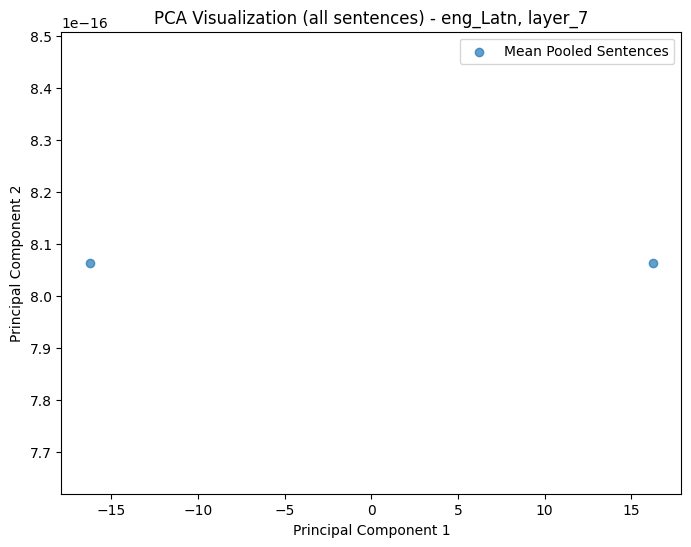

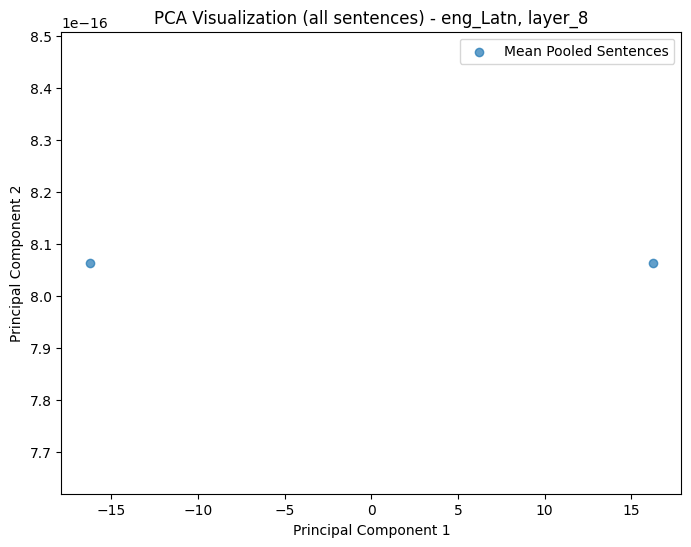

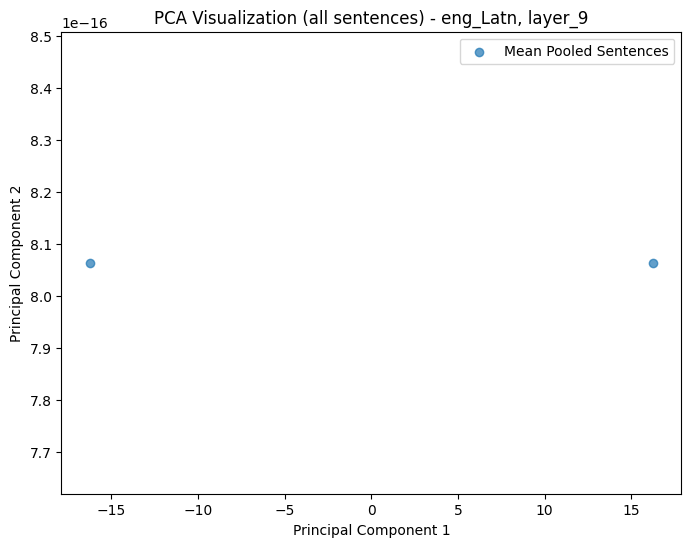


#######################################################################################

tSNE visualizations, all sentences, all layers, 1 language (eng_Latn)


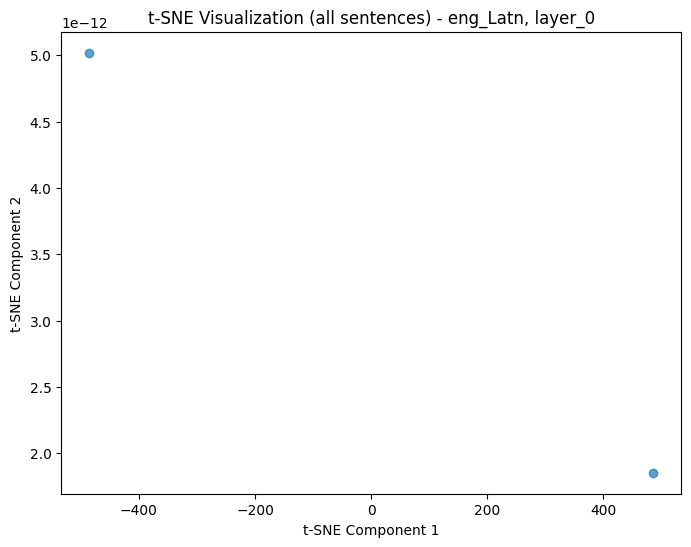

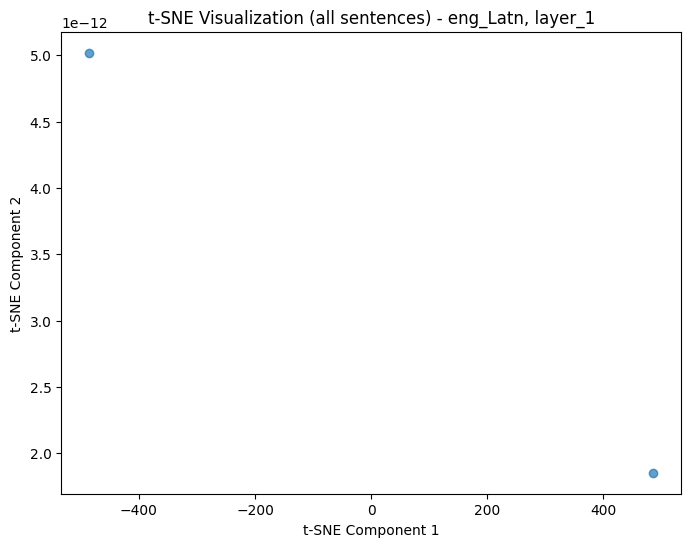

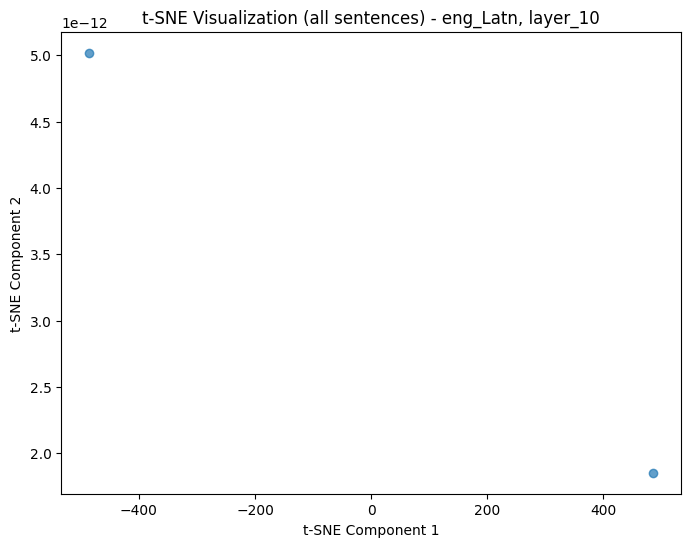

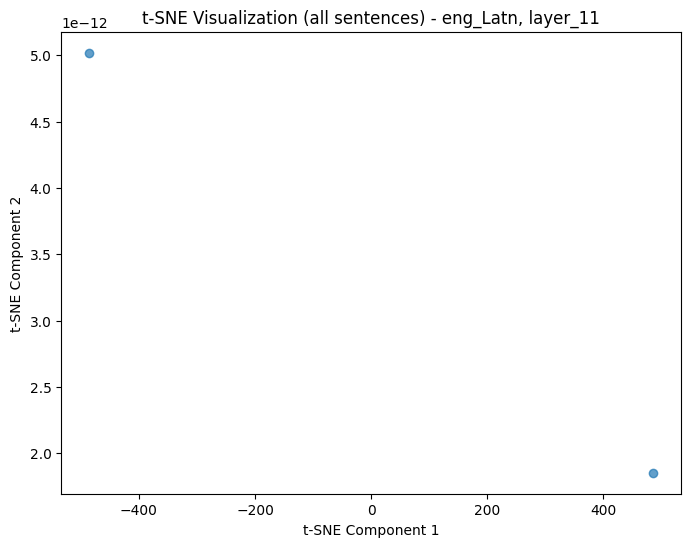

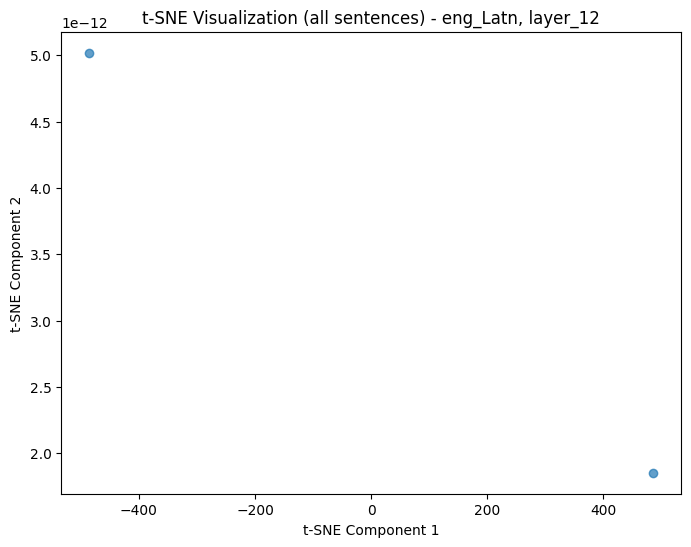

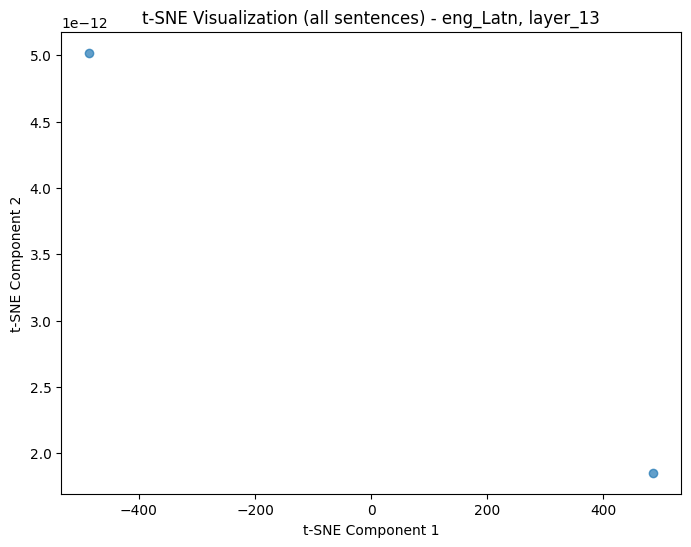

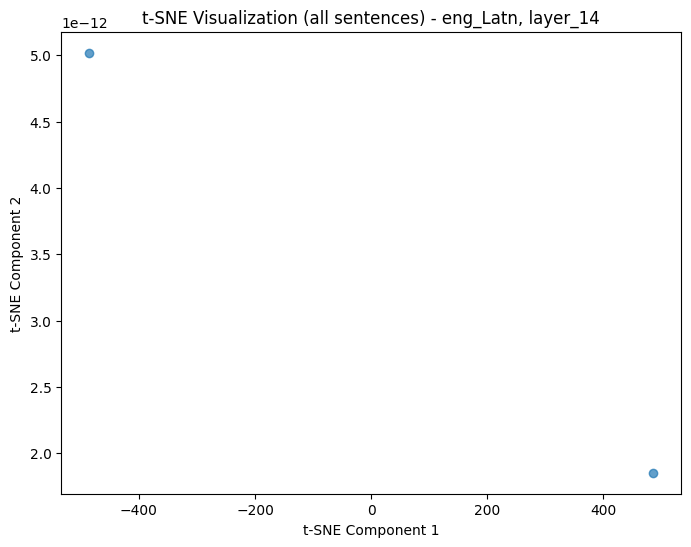

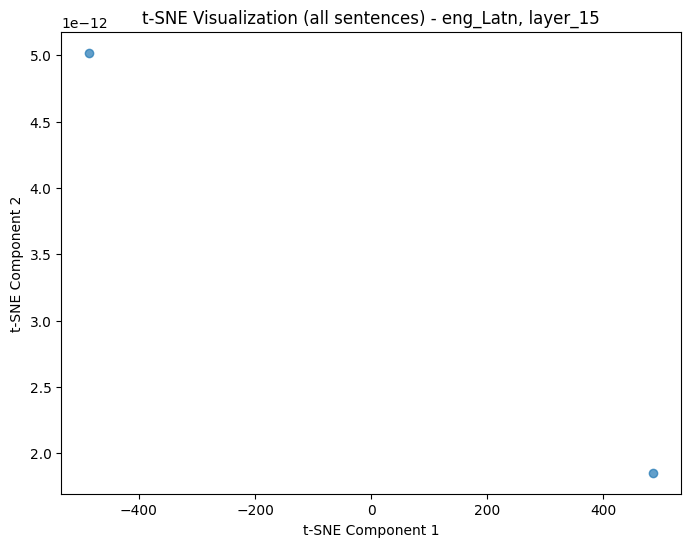

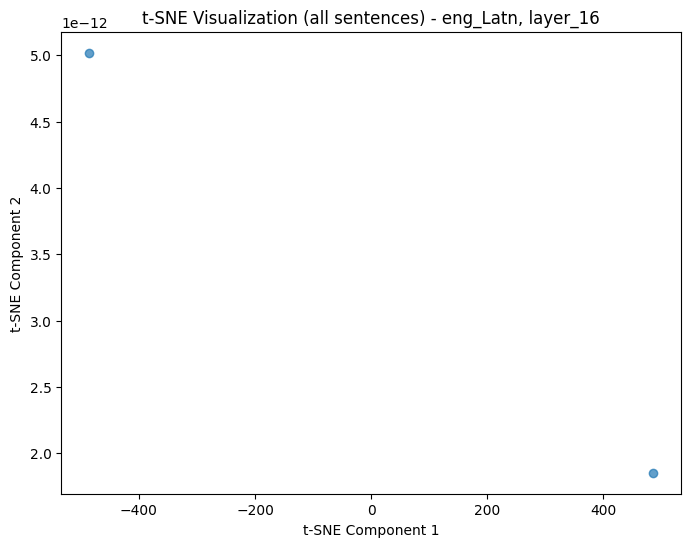

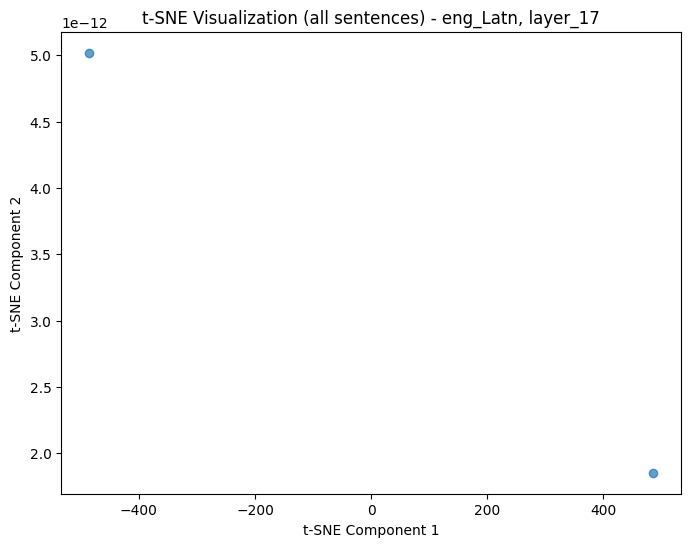

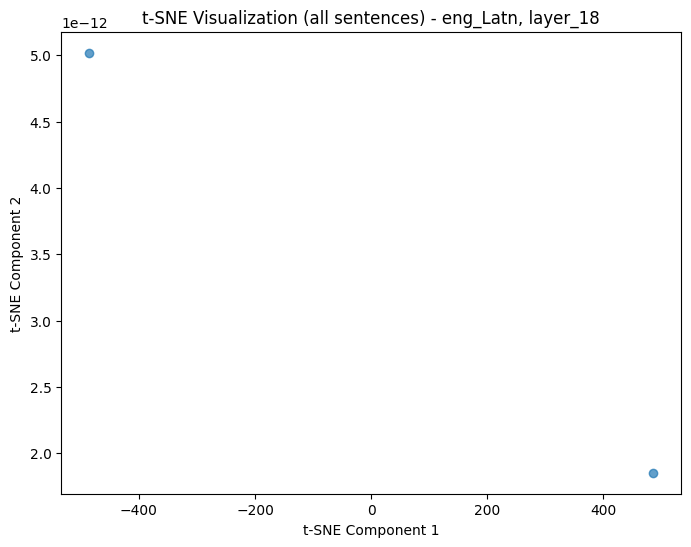

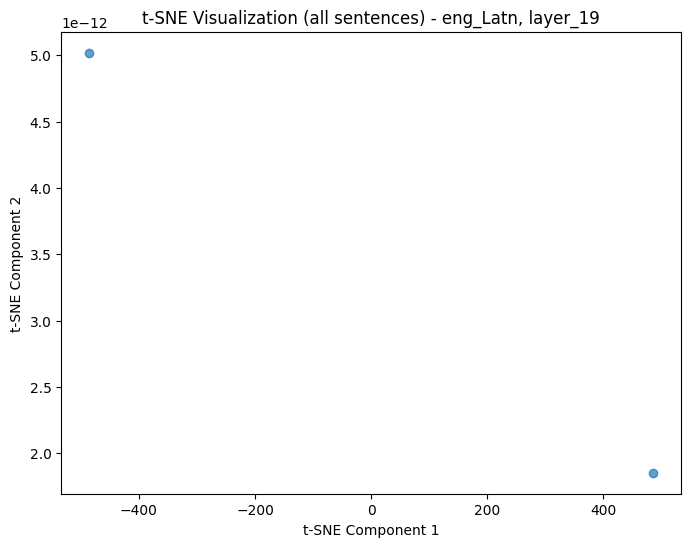

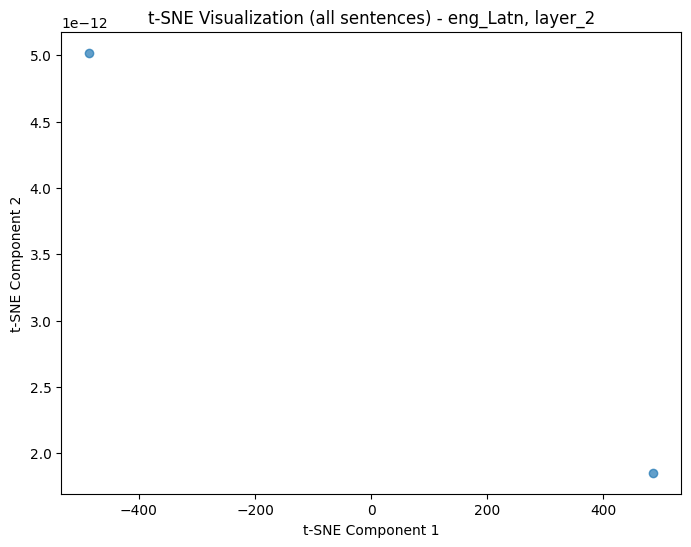

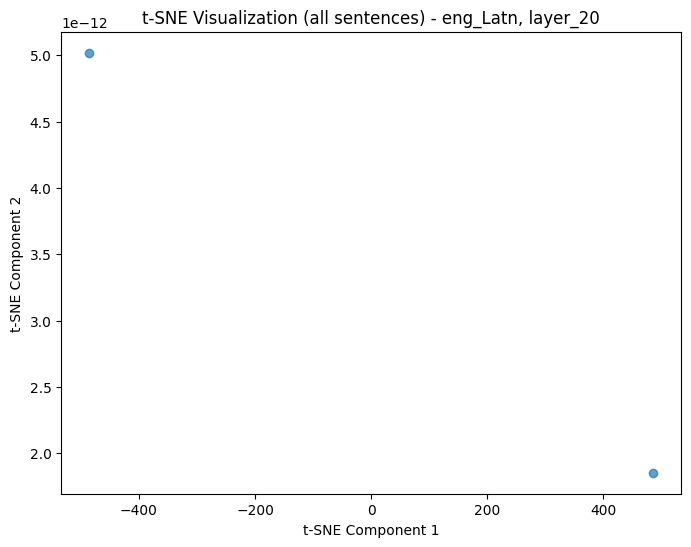

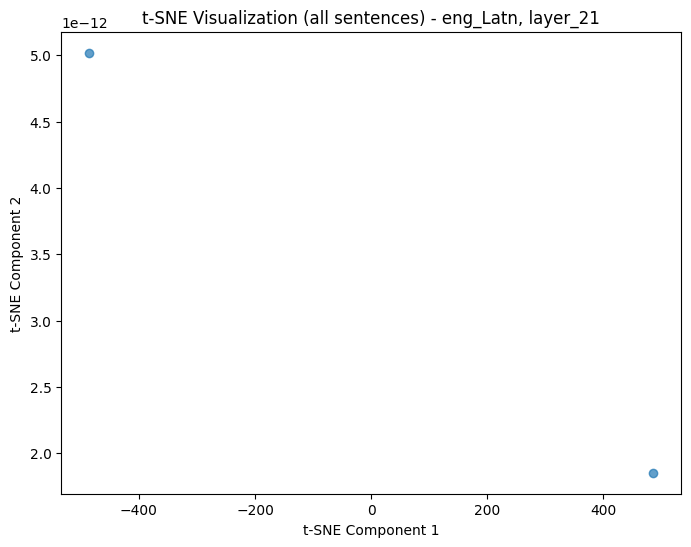

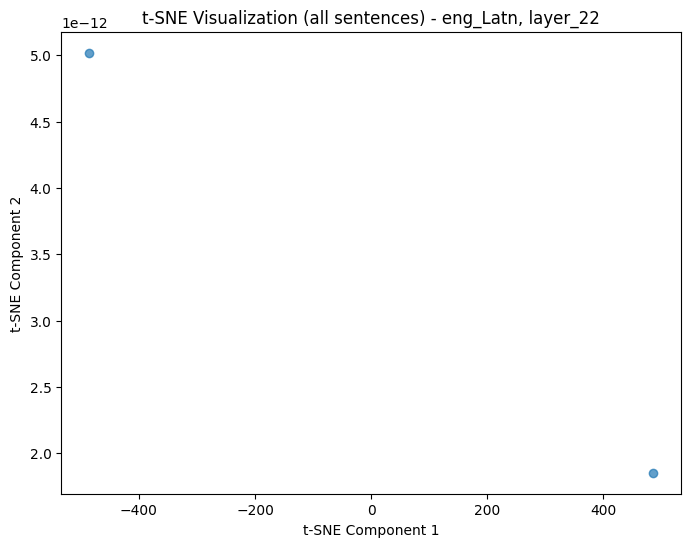

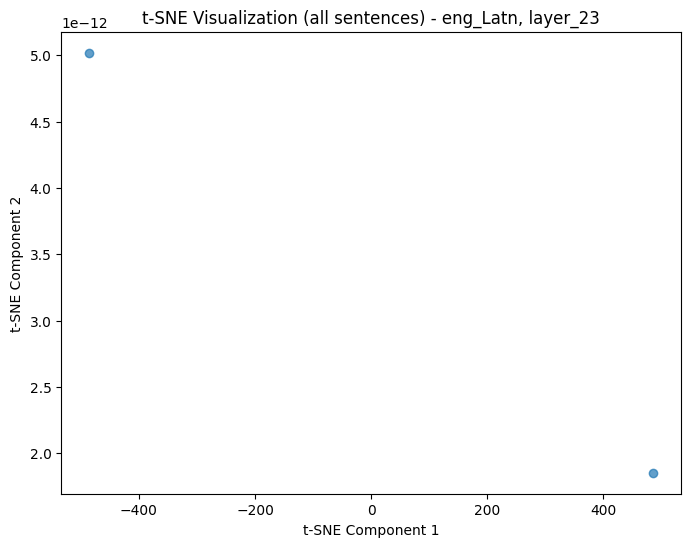

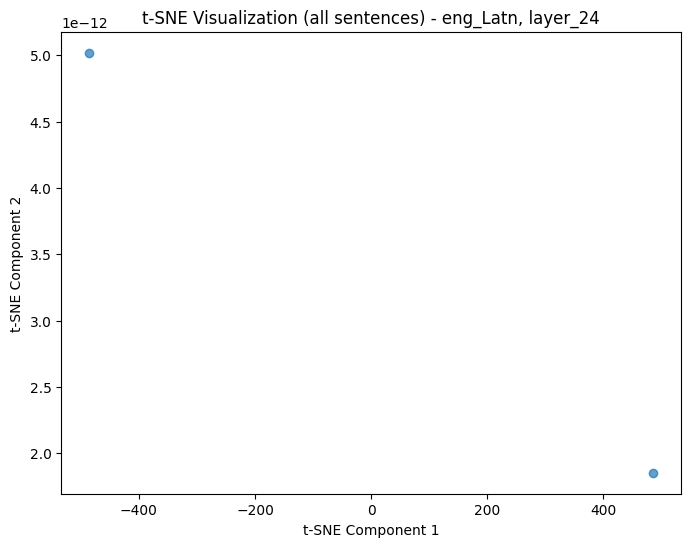

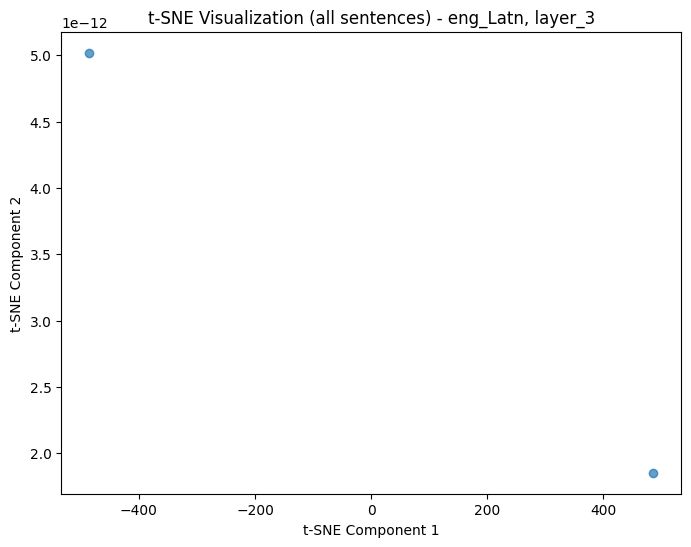

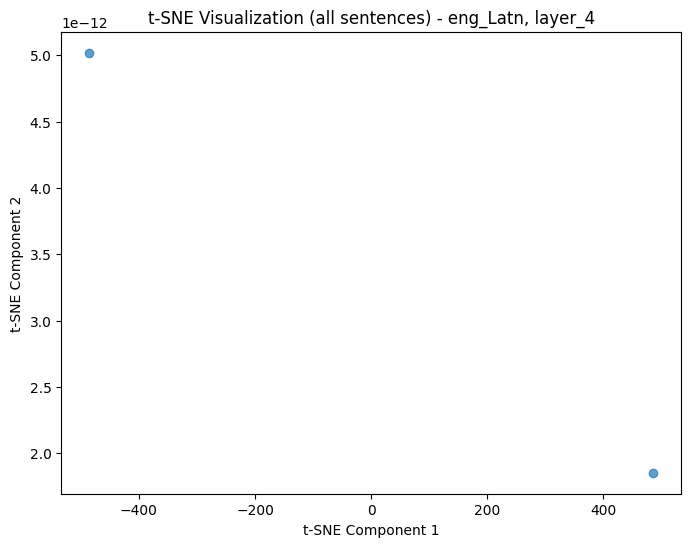

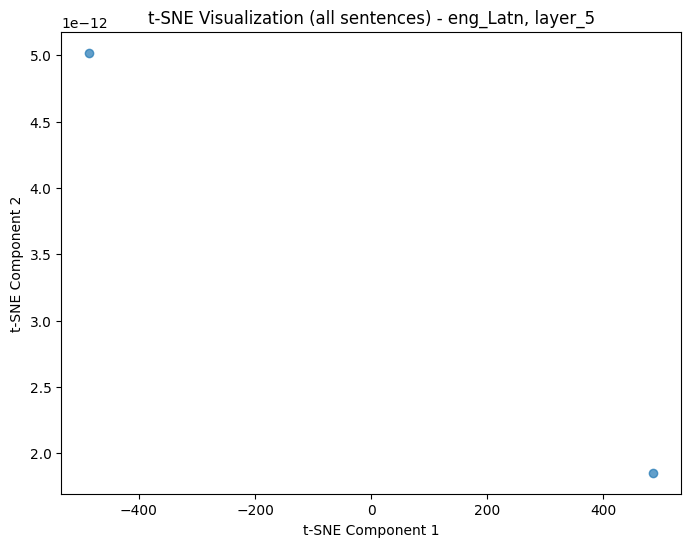

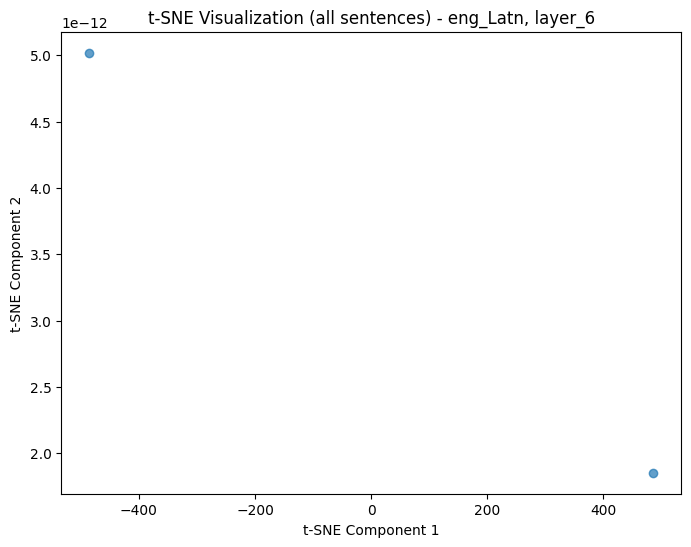

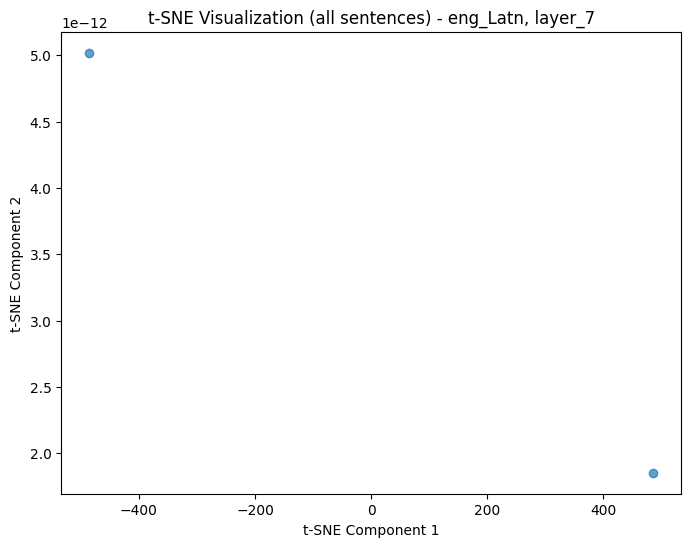

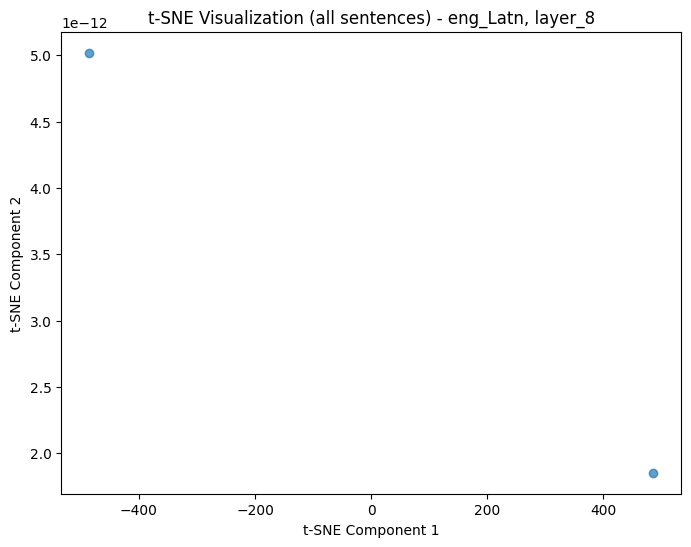

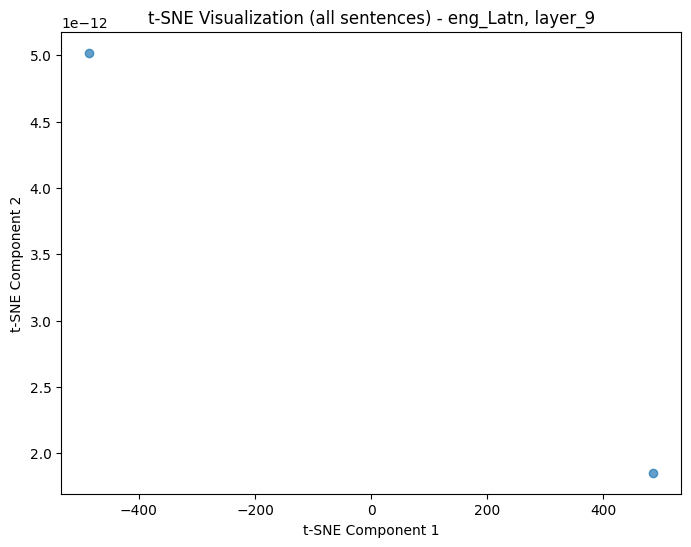

In [151]:
with h5py.File(FILE_PATH, "r") as f:

    list_langs = list(f.keys())
    # print(list_langs)
    list_sample_ids = list(f[list_langs[0]].keys())
    # print(list_sample_ids)
    list_layer_ids = list(f[list_langs[0]][list_sample_ids[0]].keys())
    # print(list_layer_ids)

    # visualize all sentences on all layers for any 1 language (mean-pooled sentences only)
    lang_index = 2

    mean_pooled_samples = []
    for sample_index in range(len(list_sample_ids)):
        mean_pooled_samples.append(f[f"{list_langs[lang_index]}/{list_sample_ids[sample_index]}/{list_layer_ids[layer_index]}/mean_pooled_sentence"])

    # PCA visualizations
    print(f'PCA visualizations, all sentences, all layers, 1 language ({list_langs[lang_index]})')
    for layer_index in range(len(list_layer_ids)):
        pca_visualize_all_sentences_one_layer_one_language(mean_pooled_samples, list_langs[lang_index], list_layer_ids[layer_index])
        print()

    print('#######################################################################################')
    print()
    # tSNE visualizations
    print(f'tSNE visualizations, all sentences, all layers, 1 language ({list_langs[lang_index]})')
    for layer_index in range(len(list_layer_ids)):
        tsne_visualize_all_sentences_one_layer_one_language(mean_pooled_samples, list_langs[lang_index], list_layer_ids[layer_index])
        print()


### Visualizations, 1 sentence on 1 layer for all languages

### Visualizations, 1 sentence on all layers for all languages